In [2]:
import pypsa
from pypsa.optimization.compat import define_constraints, get_var, join_exprs, linexpr
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pandas as pd 
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite, res_capacity_atlite, region_plotting
from interconnectors import calculate_flows, efficiency_link, calculate_distance
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")
#warnings.filterwarnings("ignore", category=UserWArning, message="warnings.filterwarnings("ignore", category=FutureWarning, message="

# Setup of global grid

### Interconnectors

In [38]:
# DISTIANCES BETWEEN NODES
for key, value in links_dic.items():
    value["length"] = calculate_distance(value["bus0"][1], value["bus1"][1])

# EFFICIENCY OF INTERCONNECTORS
cable_capacity = 1200 # MW
cable_voltage = 1100 # kV
cable_resistivity = 0.01286 # ohms/km
converter_losses = 0.015 # [-]
for key, value in links_dic.items():
    value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

# SYNTHETIC -> excludes Europe and USA
path = "/Volumes/fi246disk/synde/resources/gegis/output"
load_profile_dic = {}
for key, value in regions_dic.items():
    load_profile_dic[key] = {}
    if key != "north_america" and key != "europe" and key != "alaska":
        load_profile_dic[key]["load"] = syntheticdemand_gis(path, key, "ssp1-26" )

# HISTORIC -> includes Europe and USA
demand_mult_ssp1_26_oecd = 1.36
load_profile_dic["europe"]["load"] = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv', 2017, demand_mult_ssp1_26_oecd)
historic_load_usa = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_usa_2017_utc.csv', 2017, demand_mult_ssp1_26_oecd)
synthetic_load_north_america_no_usa = syntheticdemand_gis(path, "north_america_no_usa", "ssp1-26")
load_profile_dic["north_america"]["load"] = historic_load_usa + synthetic_load_north_america_no_usa

# RENEWABLE PROFILES
res_potential_dic = {}
for key, value in regions_dic.items():
    #if key != "oceania": #and key != "south_asia" and key != "middle_east" and key != "europe" and key != "north_africa":
    res_potential_dic[key] = {}
    res_potential_dic[key]["wind"] = vre_gen_potential_atlite(key, "wind", 2023, density=5, land_available=0.08)
    res_potential_dic[key]["pv"] = vre_gen_potential_atlite(key, "pv", 2023, density=45, land_available=0.05)




### PyPSA --> Create the grid (actual grid)

In [39]:
# Initialise the network
n = pypsa.Network() 
snapshots = pd.date_range(start="2050-01-01 00:00:00", end="2050-12-31 23:00:00", freq="h")
n.set_snapshots(snapshots)

# Loop over the dictionary to add the buses
for key, value in regions_dic.items():
    n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
    
# Loop over the dictionary to add the links
for key, value in links_dic.items():
    n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=1, p_nom_max= np.inf, p_nom_extendable=True)
    n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=1, p_nom_max= np.inf, p_nom_extendable=True)

# Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
for key, value in res_potential_dic.items():
    n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=1.0, p_max_pu=value["wind"][snapshots],p_min_pu=value["wind"][snapshots], marginal_cost = 1)
    n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=1.0, p_max_pu=value["pv"][snapshots],p_min_pu=value["pv"][snapshots], marginal_cost = 1)
    n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable = True, marginal_cost = 0, sign=-1)

# Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
for key, value in load_profile_dic.items():
    n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

m = n.optimize.create_model();

n.optimize(solver_name='gurobi')

    

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.58it/s]
INFO:linopy.io: Writing time: 4.29s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vgll7_fc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vgll7_fc.lp


Reading time = 1.68 seconds


INFO:gurobipy:Reading time = 1.68 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x6cfde254


INFO:gurobipy:Model fingerprint: 0x6cfde254


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 1e+08]


INFO:gurobipy:  RHS range        [1e+00, 1e+08]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.56438456e+14 -2.20681497e+13  4.76e+03 1.73e+06  2.44e+12     1s


INFO:gurobipy:   0   6.56438456e+14 -2.20681497e+13  4.76e+03 1.73e+06  2.44e+12     1s


   1   6.98129448e+14 -7.85164440e+13  7.16e+03 4.21e+08  1.80e+12     1s


INFO:gurobipy:   1   6.98129448e+14 -7.85164440e+13  7.16e+03 4.21e+08  1.80e+12     1s


   2   6.95682298e+14 -1.47606432e+14  6.64e+03 2.64e+08  1.21e+12     1s


INFO:gurobipy:   2   6.95682298e+14 -1.47606432e+14  6.64e+03 2.64e+08  1.21e+12     1s


   3   6.49781965e+14 -3.22398848e+14  5.21e+03 1.30e+08  7.31e+11     1s


INFO:gurobipy:   3   6.49781965e+14 -3.22398848e+14  5.21e+03 1.30e+08  7.31e+11     1s


   4   5.56438332e+14 -3.98652785e+14  2.32e+03 5.44e+07  3.31e+11     1s


INFO:gurobipy:   4   5.56438332e+14 -3.98652785e+14  2.32e+03 5.44e+07  3.31e+11     1s


   5   4.29790854e+14 -5.69383671e+14  1.17e+03 1.52e+07  1.48e+11     1s


INFO:gurobipy:   5   4.29790854e+14 -5.69383671e+14  1.17e+03 1.52e+07  1.48e+11     1s


   6   1.29513949e+14 -6.79054055e+14  2.14e+02 4.81e+06  3.21e+10     2s


INFO:gurobipy:   6   1.29513949e+14 -6.79054055e+14  2.14e+02 4.81e+06  3.21e+10     2s


   7   5.02347370e+13 -7.49189861e+14  5.23e+01 6.47e+05  8.29e+09     2s


INFO:gurobipy:   7   5.02347370e+13 -7.49189861e+14  5.23e+01 6.47e+05  8.29e+09     2s


   8   2.06646884e+13 -5.20543757e+14  1.14e+01 7.91e+04  2.16e+09     2s


INFO:gurobipy:   8   2.06646884e+13 -5.20543757e+14  1.14e+01 7.91e+04  2.16e+09     2s


   9   1.16923760e+13 -1.03044617e+14  6.78e-03 9.10e+02  2.58e+08     2s


INFO:gurobipy:   9   1.16923760e+13 -1.03044617e+14  6.78e-03 9.10e+02  2.58e+08     2s


  10   9.80249206e+12 -7.91189717e+12  0.00e+00 1.45e+02  3.97e+07     2s


INFO:gurobipy:  10   9.80249206e+12 -7.91189717e+12  0.00e+00 1.45e+02  3.97e+07     2s


  11   5.89460340e+12 -1.14918770e+12  0.00e+00 7.91e-03  1.58e+07     2s


INFO:gurobipy:  11   5.89460340e+12 -1.14918770e+12  0.00e+00 7.91e-03  1.58e+07     2s


  12   3.74617028e+12 -5.65395191e+11  0.00e+00 3.59e-03  9.65e+06     2s


INFO:gurobipy:  12   3.74617028e+12 -5.65395191e+11  0.00e+00 3.59e-03  9.65e+06     2s


  13   1.90515534e+12 -1.36192478e+11  0.00e+00 1.88e-03  4.57e+06     2s


INFO:gurobipy:  13   1.90515534e+12 -1.36192478e+11  0.00e+00 1.88e-03  4.57e+06     2s


  14   1.60287081e+12 -9.23566888e+10  0.00e+00 1.63e-03  3.79e+06     2s


INFO:gurobipy:  14   1.60287081e+12 -9.23566888e+10  0.00e+00 1.63e-03  3.79e+06     2s


  15   1.51438111e+12 -3.51794220e+10  0.00e+00 1.31e-03  3.47e+06     2s


INFO:gurobipy:  15   1.51438111e+12 -3.51794220e+10  0.00e+00 1.31e-03  3.47e+06     2s


  16   1.38088338e+12 -1.03443028e+10  0.00e+00 1.16e-03  3.11e+06     2s


INFO:gurobipy:  16   1.38088338e+12 -1.03443028e+10  0.00e+00 1.16e-03  3.11e+06     2s


  17   1.28803203e+12 -8.07562755e+09  0.00e+00 1.09e-03  2.90e+06     2s


INFO:gurobipy:  17   1.28803203e+12 -8.07562755e+09  0.00e+00 1.09e-03  2.90e+06     2s


  18   1.11178641e+12  6.16865461e+10  0.00e+00 7.01e-04  2.35e+06     2s


INFO:gurobipy:  18   1.11178641e+12  6.16865461e+10  0.00e+00 7.01e-04  2.35e+06     2s


  19   6.51987578e+11  1.23160234e+11  0.00e+00 4.39e-04  1.18e+06     2s


INFO:gurobipy:  19   6.51987578e+11  1.23160234e+11  0.00e+00 4.39e-04  1.18e+06     2s


  20   4.34454276e+11  1.64797854e+11  0.00e+00 2.73e-04  6.04e+05     3s


INFO:gurobipy:  20   4.34454276e+11  1.64797854e+11  0.00e+00 2.73e-04  6.04e+05     3s


  21   3.94314836e+11  1.75900423e+11  0.00e+00 2.15e-04  4.89e+05     3s


INFO:gurobipy:  21   3.94314836e+11  1.75900423e+11  0.00e+00 2.15e-04  4.89e+05     3s


  22   3.11549684e+11  1.87136110e+11  0.00e+00 4.67e-04  2.78e+05     3s


INFO:gurobipy:  22   3.11549684e+11  1.87136110e+11  0.00e+00 4.67e-04  2.78e+05     3s


  23   3.06774639e+11  1.89738638e+11  0.00e+00 5.77e-04  2.62e+05     3s


INFO:gurobipy:  23   3.06774639e+11  1.89738638e+11  0.00e+00 5.77e-04  2.62e+05     3s


  24   2.96682959e+11  2.02992661e+11  0.00e+00 9.57e-04  2.10e+05     3s


INFO:gurobipy:  24   2.96682959e+11  2.02992661e+11  0.00e+00 9.57e-04  2.10e+05     3s


  25   2.74766470e+11  2.17520176e+11  0.00e+00 1.16e-04  1.28e+05     3s


INFO:gurobipy:  25   2.74766470e+11  2.17520176e+11  0.00e+00 1.16e-04  1.28e+05     3s


  26   2.73209274e+11  2.20172244e+11  0.00e+00 7.79e-04  1.19e+05     3s


INFO:gurobipy:  26   2.73209274e+11  2.20172244e+11  0.00e+00 7.79e-04  1.19e+05     3s


  27   2.57249850e+11  2.27911234e+11  0.00e+00 6.44e-05  6.57e+04     3s


INFO:gurobipy:  27   2.57249850e+11  2.27911234e+11  0.00e+00 6.44e-05  6.57e+04     3s


  28   2.54505966e+11  2.30066699e+11  0.00e+00 2.00e-03  5.47e+04     3s


INFO:gurobipy:  28   2.54505966e+11  2.30066699e+11  0.00e+00 2.00e-03  5.47e+04     3s


  29   2.51259918e+11  2.31133008e+11  0.00e+00 3.49e-03  4.50e+04     3s


INFO:gurobipy:  29   2.51259918e+11  2.31133008e+11  0.00e+00 3.49e-03  4.50e+04     3s


  30   2.48720844e+11  2.31649447e+11  0.00e+00 3.54e-03  3.82e+04     3s


INFO:gurobipy:  30   2.48720844e+11  2.31649447e+11  0.00e+00 3.54e-03  3.82e+04     3s


  31   2.48224386e+11  2.32345313e+11  0.00e+00 1.38e-03  3.55e+04     3s


INFO:gurobipy:  31   2.48224386e+11  2.32345313e+11  0.00e+00 1.38e-03  3.55e+04     3s


  32   2.43243775e+11  2.33490668e+11  0.00e+00 2.98e-05  2.18e+04     3s


INFO:gurobipy:  32   2.43243775e+11  2.33490668e+11  0.00e+00 2.98e-05  2.18e+04     3s


  33   2.41959816e+11  2.34143211e+11  0.00e+00 6.08e-04  1.75e+04     4s


INFO:gurobipy:  33   2.41959816e+11  2.34143211e+11  0.00e+00 6.08e-04  1.75e+04     4s


  34   2.39559277e+11  2.34734412e+11  0.00e+00 8.25e-05  1.08e+04     4s


INFO:gurobipy:  34   2.39559277e+11  2.34734412e+11  0.00e+00 8.25e-05  1.08e+04     4s


  35   2.38934093e+11  2.35041731e+11  0.00e+00 3.29e-04  8.71e+03     4s


INFO:gurobipy:  35   2.38934093e+11  2.35041731e+11  0.00e+00 3.29e-04  8.71e+03     4s


  36   2.38536592e+11  2.35178949e+11  0.00e+00 3.65e-03  7.51e+03     4s


INFO:gurobipy:  36   2.38536592e+11  2.35178949e+11  0.00e+00 3.65e-03  7.51e+03     4s


  37   2.37545399e+11  2.35262660e+11  0.00e+00 4.17e-03  5.11e+03     4s


INFO:gurobipy:  37   2.37545399e+11  2.35262660e+11  0.00e+00 4.17e-03  5.11e+03     4s


  38   2.36906421e+11  2.35330718e+11  0.00e+00 4.57e-03  3.53e+03     4s


INFO:gurobipy:  38   2.36906421e+11  2.35330718e+11  0.00e+00 4.57e-03  3.53e+03     4s


  39   2.36544644e+11  2.35406738e+11  0.00e+00 7.23e-03  2.55e+03     4s


INFO:gurobipy:  39   2.36544644e+11  2.35406738e+11  0.00e+00 7.23e-03  2.55e+03     4s


  40   2.36066112e+11  2.35438050e+11  0.00e+00 5.54e-03  1.41e+03     4s


INFO:gurobipy:  40   2.36066112e+11  2.35438050e+11  0.00e+00 5.54e-03  1.41e+03     4s


  41   2.35871820e+11  2.35448820e+11  0.00e+00 3.27e-03  9.47e+02     4s


INFO:gurobipy:  41   2.35871820e+11  2.35448820e+11  0.00e+00 3.27e-03  9.47e+02     4s


  42   2.35719504e+11  2.35456476e+11  0.00e+00 2.63e-03  5.89e+02     4s


INFO:gurobipy:  42   2.35719504e+11  2.35456476e+11  0.00e+00 2.63e-03  5.89e+02     4s


  43   2.35624077e+11  2.35461332e+11  0.00e+00 1.72e-03  3.64e+02     5s


INFO:gurobipy:  43   2.35624077e+11  2.35461332e+11  0.00e+00 1.72e-03  3.64e+02     5s


  44   2.35568764e+11  2.35467029e+11  0.00e+00 4.87e-04  2.28e+02     5s


INFO:gurobipy:  44   2.35568764e+11  2.35467029e+11  0.00e+00 4.87e-04  2.28e+02     5s


  45   2.35548214e+11  2.35470859e+11  0.00e+00 3.72e-04  1.73e+02     5s


INFO:gurobipy:  45   2.35548214e+11  2.35470859e+11  0.00e+00 3.72e-04  1.73e+02     5s


  46   2.35533574e+11  2.35473782e+11  0.00e+00 2.06e-04  1.34e+02     5s


INFO:gurobipy:  46   2.35533574e+11  2.35473782e+11  0.00e+00 2.06e-04  1.34e+02     5s


  47   2.35511082e+11  2.35477522e+11  0.00e+00 1.66e-04  7.51e+01     5s


INFO:gurobipy:  47   2.35511082e+11  2.35477522e+11  0.00e+00 1.66e-04  7.51e+01     5s


  48   2.35495781e+11  2.35478958e+11  0.00e+00 1.28e-04  3.77e+01     5s


INFO:gurobipy:  48   2.35495781e+11  2.35478958e+11  0.00e+00 1.28e-04  3.77e+01     5s


  49   2.35487594e+11  2.35480375e+11  0.00e+00 2.65e-05  1.62e+01     5s


INFO:gurobipy:  49   2.35487594e+11  2.35480375e+11  0.00e+00 2.65e-05  1.62e+01     5s


  50   2.35484055e+11  2.35480651e+11  0.00e+00 1.76e-05  7.62e+00     5s


INFO:gurobipy:  50   2.35484055e+11  2.35480651e+11  0.00e+00 1.76e-05  7.62e+00     5s


  51   2.35482294e+11  2.35480909e+11  0.00e+00 4.82e-05  3.10e+00     5s


INFO:gurobipy:  51   2.35482294e+11  2.35480909e+11  0.00e+00 4.82e-05  3.10e+00     5s


  52   2.35481677e+11  2.35480998e+11  1.35e-07 5.67e-05  1.52e+00     5s


INFO:gurobipy:  52   2.35481677e+11  2.35480998e+11  1.35e-07 5.67e-05  1.52e+00     5s


  53   2.35481251e+11  2.35481048e+11  3.67e-07 1.43e-05  4.54e-01     5s


INFO:gurobipy:  53   2.35481251e+11  2.35481048e+11  3.67e-07 1.43e-05  4.54e-01     5s


  54   2.35481130e+11  2.35481064e+11  3.95e-06 8.58e-06  1.48e-01     5s


INFO:gurobipy:  54   2.35481130e+11  2.35481064e+11  3.95e-06 8.58e-06  1.48e-01     5s


  55   2.35481095e+11  2.35481073e+11  8.27e-07 1.48e-05  4.85e-02     5s


INFO:gurobipy:  55   2.35481095e+11  2.35481073e+11  8.27e-07 1.48e-05  4.85e-02     5s


  56   2.35481080e+11  2.35481076e+11  4.91e-07 2.29e-05  8.83e-03     6s


INFO:gurobipy:  56   2.35481080e+11  2.35481076e+11  4.91e-07 2.29e-05  8.83e-03     6s


  57   2.35481080e+11  2.35481077e+11  8.42e-07 4.29e-06  4.96e-03     6s


INFO:gurobipy:  57   2.35481080e+11  2.35481077e+11  8.42e-07 4.29e-06  4.96e-03     6s


INFO:gurobipy:


Barrier solved model in 57 iterations and 5.68 seconds (6.20 work units)


INFO:gurobipy:Barrier solved model in 57 iterations and 5.68 seconds (6.20 work units)


Optimal objective 2.35481080e+11


INFO:gurobipy:Optimal objective 2.35481080e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  110929 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:  110929 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:


    9395 PPushes remaining with PInf 1.2329768e-03                 8s


INFO:gurobipy:    9395 PPushes remaining with PInf 1.2329768e-03                 8s


       0 PPushes remaining with PInf 2.4274822e-05                 9s


INFO:gurobipy:       0 PPushes remaining with PInf 2.4274822e-05                 9s


INFO:gurobipy:


  Push phase complete: Pinf 2.4274822e-05, Dinf 1.6165777e+04      9s


INFO:gurobipy:  Push phase complete: Pinf 2.4274822e-05, Dinf 1.6165777e+04      9s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   77787    2.3548108e+11   0.000000e+00   1.616578e+04      9s


INFO:gurobipy:   77787    2.3548108e+11   0.000000e+00   1.616578e+04      9s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 17


INFO:gurobipy:Extra simplex iterations after uncrush: 17


   77807    2.3548108e+11   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:   77807    2.3548108e+11   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:


Solved in 77807 iterations and 9.52 seconds (11.60 work units)


INFO:gurobipy:Solved in 77807 iterations and 9.52 seconds (11.60 work units)


Optimal objective  2.354810794e+11


INFO:gurobipy:Optimal objective  2.354810794e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 2.35e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [46]:
n.generators.p_nom_opt

Generator
wind_north_america             9.890490e-02
pv_north_america               3.029211e-01
curtailment_north_america      1.073088e+08
wind_latin_america             3.565558e-01
pv_latin_america               1.000000e+00
curtailment_latin_america      3.243915e+07
wind_oceania                   3.085524e-01
pv_oceania                     0.000000e+00
curtailment_oceania            5.559747e+05
wind_north_asia                1.000000e+00
pv_north_asia                  7.887060e-02
curtailment_north_asia         3.624107e+06
wind_south_asia                1.000000e+00
pv_south_asia                  6.210049e-02
curtailment_south_asia         4.100593e+05
wind_north_west_asia           1.000000e+00
pv_north_west_asia             0.000000e+00
curtailment_north_west_asia    2.339682e+06
wind_south_west_asia           1.000000e+00
pv_south_west_asia             6.984919e-02
curtailment_south_west_asia    4.481016e+05
wind_middle_east               1.000000e+00
pv_middle_east        

In [24]:
# THIS WORKS, NEXT STEP IS TO PLOT IT
sum_timesteps = True
balances = []
outflows = []
generations = []
loads = []
slacks = []
curtailments = []
netflows = []
inflows = []
for snapshot in snapshots:
    buses = []
    balances_ = []
    outflows_ = []
    generations_ = []
    curtailments_ = []
    inflows_ = []
    netflows_ = []
    loads_ = []
    for bus in n.buses.index:
        vre_generators = n.generators[(n.generators['bus'] == bus) & ((n.generators['type'] == "Wind") | (n.generators['type'] == "PV"))]
        cur_generators = n.generators[(n.generators['bus'] == bus) & (n.generators['type'] == "Curtailment")]
        vre_p = n.generators_t.p.loc[snapshot, vre_generators.index].sum()
        cur_p = n.generators_t.p.loc[snapshot, cur_generators.index].sum()
        outflow = 0
        inflow = 0
        load = n.loads_t.p_set.loc[snapshot][f'load_{bus}']
        for link in n.links.index:
            if bus == n.links["bus0"][link]:
                outflow -= n.links_t.p0.loc[snapshot][link]
            if bus == n.links["bus1"][link]:
                inflow -= n.links_t.p1.loc[snapshot][link]
            netflow = outflow + inflow
        balance = vre_p - load - cur_p + netflow
        balances_.append(balance)
        outflows_.append(outflow)
        inflows_.append(inflow)
        netflows_.append(netflow)
        generations_.append(vre_p)
        curtailments_.append(cur_p)
        loads_.append(load)
    balances.append(balances_)
    outflows.append(outflows_)
    inflows.append(inflows_)
    generations.append(generations_)
    curtailments.append(curtailments_)
    loads.append(loads_)
    netflows.append(netflows_)

# Convert lists to numpy arrays for easier indexing
balances = np.array(balances)
outflows = np.array(outflows) 
inflows = np.array(inflows)
netflows = np.array(netflows)
generations = np.array(generations)
curtailments = np.array(curtailments)
loads = np.array(loads)
total_balance = np.sum(generations) - np.sum(curtailments)- np.sum(loads)
print('Total balance:',total_balance)

KeyboardInterrupt: 

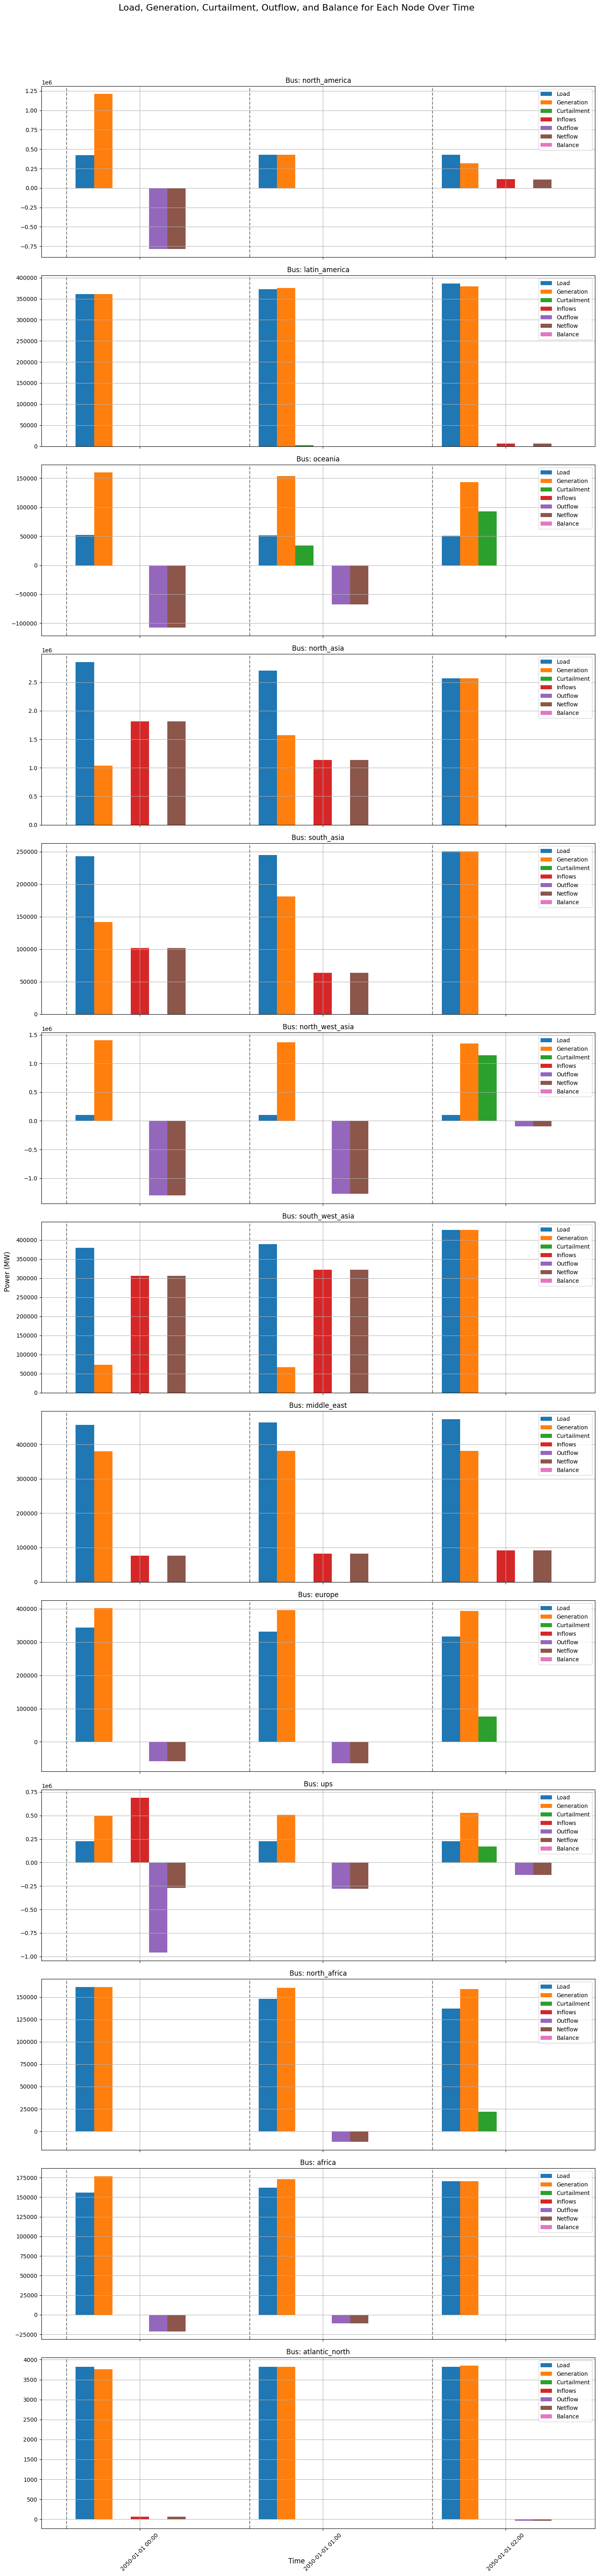

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure all sublists have the same length
num_buses = len(n.buses.index)

# Number of snapshots
num_snapshots = len(snapshots)

# Create subplots for each bus
fig, axes = plt.subplots(num_buses, 1, figsize=(15, num_buses * 5), sharex=True)

# If there's only one bus, make sure axes is iterable
if num_buses == 1:
    axes = [axes]

# Plot data for each bus
bar_width = 0.1  # Adjust bar width to fit all bars within each time step
for i, bus in enumerate(n.buses.index):
    ax = axes[i]
    indices = np.arange(num_snapshots)
    
    # Calculate total width for all bars
    total_width = 6 * bar_width  # 6 because we have 6 types of data to plot

    # Plot load
    ax.bar(indices - total_width/2 + 0 * bar_width, loads[:, i], bar_width, label='Load')
    
    # Plot generation
    ax.bar(indices - total_width/2 + 1 * bar_width, generations[:, i], bar_width, label='Generation')

    # Plot curtailment
    ax.bar(indices - total_width/2 + 2 * bar_width, curtailments[:, i], bar_width, label='Curtailment')
    
    # Plot inflows
    ax.bar(indices - total_width/2 + 3 * bar_width, inflows[:, i], bar_width, label='Inflows')

    # Plot outflows
    ax.bar(indices - total_width/2 + 4 * bar_width, outflows[:, i], bar_width, label='Outflow')

    # Plot netflows
    ax.bar(indices - total_width/2 + 5 * bar_width, netflows[:, i], bar_width, label='Netflow')
    
    # Plot balances
    ax.bar(indices - total_width/2 + 6 * bar_width, balances[:, i], bar_width, label='Balance')
    
    # Add vertical lines to separate time steps
    for idx in indices:
        ax.axvline(x=idx - total_width/2 - bar_width, color='gray', linestyle='--')

    ax.set_title(f"Bus: {bus}")
    ax.set_xticks(indices)
    ax.set_xticklabels(snapshots.strftime('%Y-%m-%d %H:%M'), rotation=45)
    ax.legend()
    ax.grid(True)

# Set overall plot title and labels
fig.suptitle('Load, Generation, Curtailment, Outflow, and Balance for Each Node Over Time', fontsize=16)
fig.supxlabel('Time')
fig.supylabel('Power (MW)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Analysis of global grid

### Installed capacity, generation, load, and curtailment

In [17]:
n.links_t.p0

Link,north_america_to_latin_america,north_america_to_ups,north_america_to_atlantic_north,oceania_to_south_asia,north_asia_to_south_asia,north_asia_to_north_west_asia,north_asia_to_south_west_asia,north_asia_to_ups,north_west_asia_to_south_west_asia,north_west_asia_to_middle_east,north_west_asia_to_ups,middle_east_to_europe,middle_east_to_ups,middle_east_to_north_africa,middle_east_to_africa,europe_to_ups,europe_to_north_africa,europe_to_atlantic_north,north_africa_to_africa
snapshot,,,,,,,,,,,,,,,,,,,
2050-01-01 00:00:00,405264.178231,-8.323178e+05,4143.190751,-52067.209153,314599.554895,-1.293686e+08,1.251776e+08,1.025082e+06,-1.225756e+08,1.233185e+06,0.0,365840.961663,0.0,173394.987502,170043.233457,0.0,0.0,0.0,0.0
2050-01-01 01:00:00,418994.021799,-8.493861e+05,4143.190751,-51651.073519,316393.435512,-1.265162e+08,1.224524e+08,1.040106e+06,-1.198884e+08,1.218601e+06,0.0,352541.413499,0.0,159170.737614,176824.720376,0.0,0.0,0.0,0.0
2050-01-01 02:00:00,433546.193071,-8.641101e+05,4143.190751,-50728.872450,320946.634243,-1.246005e+08,1.206581e+08,1.050669e+06,-1.180861e+08,1.209482e+06,0.0,337609.222309,0.0,147100.452946,186040.112147,0.0,0.0,0.0,0.0
2050-01-01 03:00:00,435452.818669,-8.663676e+05,4143.190751,-49851.944334,324609.524885,-1.222772e+08,1.184744e+08,1.049247e+06,-1.159061e+08,1.205921e+06,0.0,327354.829508,0.0,140569.697294,195442.724062,0.0,0.0,0.0,0.0
2050-01-01 04:00:00,434174.952777,-8.630765e+05,4143.190751,-46726.281704,331040.204114,-1.195435e+08,1.158860e+08,1.043856e+06,-1.133435e+08,1.205912e+06,0.0,323806.398179,0.0,137663.714917,197945.495373,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-12-31 19:00:00,414894.595709,-1.115314e+06,3959.416351,-50705.298610,318423.821285,-1.358832e+08,1.313940e+08,1.287942e+06,-1.286998e+08,1.269425e+06,0.0,393384.329669,0.0,182048.739560,172507.782813,0.0,0.0,0.0,0.0
2050-12-31 20:00:00,411469.749338,-1.113189e+06,4133.372363,-50754.487237,307593.593395,-1.357623e+08,1.312613e+08,1.288031e+06,-1.285730e+08,1.252300e+06,0.0,375444.604561,0.0,187637.844570,170641.879716,0.0,0.0,0.0,0.0
2050-12-31 21:00:00,387189.617025,-1.094987e+06,4223.914591,-50780.902160,304447.181150,-1.365708e+08,1.320383e+08,1.271274e+06,-1.293283e+08,1.244439e+06,0.0,369201.104841,0.0,191000.852628,167064.844298,0.0,0.0,0.0,0.0


In [40]:
year = 2050
for key, value in regions_dic.items(): # Annual (total) values
    for carrier in ["pv", "wind"]: 
        regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() # Installed capacities for each node in MW
        regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) / 1e6 # Total energy generated at each node in TWh
    
    regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) / 1e6 # Curtailment at each node in TWh
    regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0)
 
for key, value in regions_dic.items():
    for carrier in ["pv", "wind"]:
        series_g = n.generators_t.p[f"{carrier}_{key}"] 
        regions_dic[key][f"mean_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).mean() # MW
        regions_dic[key][f"total_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).sum() # MWh
        regions_dic[key][f"mean_{carrier}_daily"] = series_g.groupby(series_g.index.date).mean() # MW

    series_c = n.generators_t.p[f"curtailment_{key}"]
    regions_dic[key][f"mean_curtailment_daily"] = series_c.groupby(series_c.index.date).mean() # MW
    regions_dic[key][f"mean_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).mean() # MW
    regions_dic[key][f"total_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).sum() # MWh

    series_l = n.loads_t.p[f"load_{key}"]
    regions_dic[key][f"total_load_daily"] = series_l.groupby(series_l.index.date).mean() # MW
    regions_dic[key][f"mean_load_daily"] = series_l.groupby(series_l.index.date).mean() # MW
    regions_dic[key][f"mean_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).mean() # MW
    regions_dic[key][f"total_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).sum() # MWh
    
    

# Daily hourly values of specific days
dates = pd.to_datetime([f"{year}-03-21", f"{year}-06-21", f"{year}-09-21", f"{year}-12-21"])
for date in dates:
    for key, value in regions_dic.items():
        for carrier in ["pv", "wind"]:
            regions_dic[key][f"hourly_{carrier}_{date}"] = n.generators_t.p[f"{carrier}_{key}"].loc[date.strftime('%Y-%m-%d')] # Generation profile for specific day

        regions_dic[key][f"hourly_load_{date}"] = n.loads_t.p[f"load_{key}"].loc[date.strftime('%Y-%m-%d')] # Load profile for a specific day
        regions_dic[key][f"houtly_curtailment_{date}"] = n.generators_t.p[f"curtailment_{key}"].loc[date.strftime('%Y-%m-%d')] # Curtailment profile for specific day


In [41]:
for key, value in regions_dic.items(): # Annual (total) values
    for carrier in ["pv", "wind"]: 
        print(regions_dic[key][f"{carrier}_installed"])
        regions_dic[key][f"total_{carrier}_yearly"]

33429964.693109702
1320566.565658945
32301018.399
714490.2777516774
0.0
730912.7469087694
2629179.3521144963
3035002.97982
414150.59846847993
311148.271418
0.0
2658736.47073
646228.1367424864
693753.213348
215615.02174052052
1156729.73566
0.0
3348606.18241
0.0
3052320.6119552376
2821649.0134592457
903993.1383771405
202939.355443432
305359.30283790594
0.0
7196.4609908348475


### Link losses, inflow, and outflow

In [11]:
# Store hourly losses for each link in dictionary
for key, value in links_dic.items():
    p0, p1 = n.links_t.p0[value["name"]], n.links_t.p1[value["name"]]
    abs_losses = abs(p0 + p1)
    active_power = pd.DataFrame({'p0': p0, 'p1': p1})
    p_trans = active_power.abs().max(axis=1)
    value["hourly_p_trans"] = p_trans
    value["hourly_abs_losses"] = abs_losses

# Calculate inflow, outflow, and 
for region_key, region_value in regions_dic.items():
    inflow = 0
    outflow = 0
    for link_key, link_value in links_dic.items():
        if region_value["bus"] == link_value["bus0"][0]:
            p0 = n.links_t.p0[link_value["name"]]
            sum_p0 = sum(p0)
            if sum_p0 > 0:
                outflow += p0
            elif sum_p0 <0:
                inflow += p0
    region_value["inflow"] = abs(inflow)
    region_value["outflow"] = outflow
    region_value["netflow"] = abs(inflow) - outflow

# Compute inflow, outflow direction per link
flow_statements = []
for link_key, link_value in links_dic.items():
    p0 = n.links_t.p0[link_value["name"]]
    sum_p0 = sum(p0)
    if sum_p0 > 0:
        flow_statement = True # outflow
    else:
        flow_statement = False
    flow_statements.append(flow_statement)

arrow_colours = [n.links_t.p0[link_value["name"]] for link_key, link_value in links_dic.items()]

# Sum the losses of the links
total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
total_hourly_p_trans = pd.Series(0, index=n.snapshots)
for key, value in links_dic.items():
    total_hourly_abs_losses += value["hourly_abs_losses"]
    total_hourly_p_trans += value["hourly_p_trans"]

# Absolute losses
total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
total_annual_abs_losses = total_hourly_abs_losses.sum()

# Power transmitted
total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
total_annual_p_trans = total_hourly_p_trans.sum()

# Relative losses
daily_rel_losses = total_daily_abs_losses / total_daily_p_trans
monthly_rel_losses = total_monthly_abs_losses / total_monthly_p_trans
annual_rel_losses = total_annual_abs_losses / total_annual_p_trans

# Statistics of the losses
mean_losses = total_hourly_abs_losses.mean()
std_losses = total_hourly_abs_losses.std()
daily_deviation = daily_rel_losses - daily_rel_losses.mean()
monthly_deviation = monthly_rel_losses - monthly_rel_losses.mean()

### Losses vs load

In [12]:
# Sum loads of dictionaries
total_hourly_load = pd.Series(0, index=n.snapshots)
for key, value in regions_dic.items():
    total_hourly_load += n.loads_t.p[f"load {key}"]

# Load 
total_daily_load = total_hourly_load.groupby(total_hourly_load.index.date).sum()
total_monthly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('M')).sum()
total_annual_load = total_hourly_load.sum()

# Losses relative to load
monthly_losses_rel_to_load = total_monthly_abs_losses / total_monthly_load
annual_losses_rel_to_load = total_annual_abs_losses / total_annual_load

### Losses vs generation

In [13]:
# Sum generation of nodes
total_hourly_gen = pd.Series(0, index=n.snapshots)
for key, value in regions_dic.items():
    total_hourly_gen += n.generators_t.p[f"wind {key}"] + n.generators_t.p[f"pv {key}"]

# Generation 
total_daily_gen = total_hourly_gen.groupby(total_hourly_gen.index.date).sum()
total_monthly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('M')).sum()
total_annual_gen = total_hourly_gen.sum()

# Losses relative to gen
hourly_losses_rel_to_gen = total_hourly_abs_losses / total_hourly_gen
daily_losses_rel_to_gen = total_daily_abs_losses / total_daily_gen
monthly_losses_rel_to_gen = total_monthly_abs_losses / total_monthly_gen
annual_losses_rel_to_gen = total_annual_abs_losses / total_annual_gen

# Statistics of the losses
daily_deviation_gen = daily_losses_rel_to_gen - daily_losses_rel_to_gen.mean()
monthly_deviation_gen = monthly_losses_rel_to_gen - monthly_losses_rel_to_gen.mean()

/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_6030/3455698351.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  annual_losses_rel_to_gen = total_annual_abs_losses / total_annual_gen


In [15]:
hourly_losses_rel_to_gen

snapshot
2050-01-01 00:00:00    inf
2050-01-01 01:00:00    inf
2050-01-01 02:00:00    inf
2050-01-01 03:00:00    inf
2050-01-01 04:00:00    inf
                      ... 
2050-12-31 19:00:00    inf
2050-12-31 20:00:00    inf
2050-12-31 21:00:00    inf
2050-12-31 22:00:00    inf
2050-12-31 23:00:00    inf
Freq: h, Length: 8760, dtype: float64

In [16]:
flow = pd.Series(10, index=n.branches().index)

In [17]:
gen = n.generators.assign(g=n.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum()
transmission = n.links.assign(g=n.links_t.p0.mean()).groupby(["Link"]).g.sum()

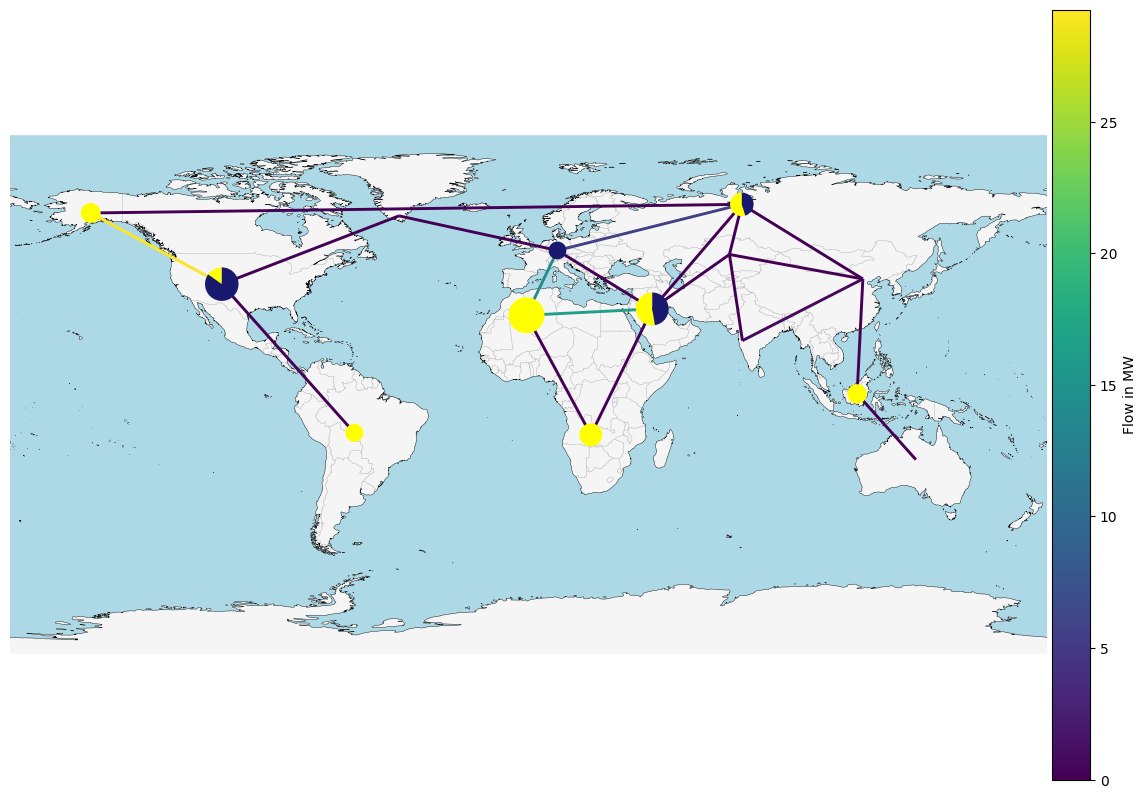

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors


# Plot the network with arrows indicating flow direction
collection = n.plot(
    bus_sizes=gen / 5,
    bus_colors={"wind": "midnightblue", "pv": "yellow", "curtailment": "red"},
    flow=flow,
    line_widths=2.7,
    link_widths=2.1,
    color_geomap=True,
    link_colors=n.links_t.p0.mean().abs(),
    boundaries=[-180, 180, -90, 90],
)
# Add colorbar for flow
plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")

plt.show()


## Plotting of just the map

/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_88499/879127582.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


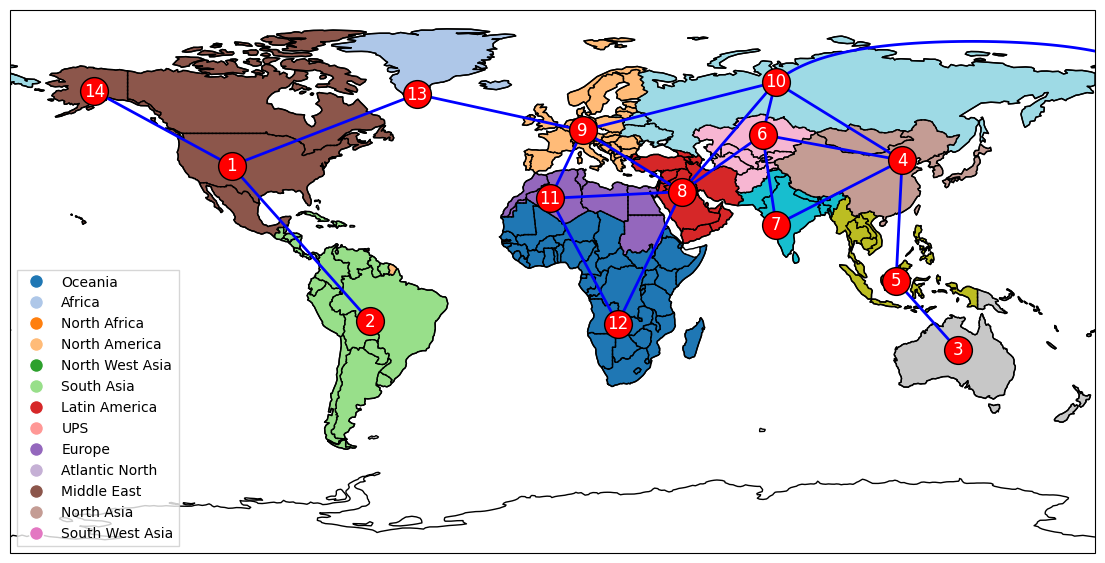

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend
world.plot(ax=ax, column='bus', cmap='tab20', legend=False, edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(n.buses.index, start=1):
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Define the Geod object for WGS84
geod = Geod(ellps="WGS84")

# Plot links
for link in n.links.index:
    bus0 = n.links.loc[link, 'bus0']
    bus1 = n.links.loc[link, 'bus1']
    x0, y0 = n.buses.loc[bus0, ['x', 'y']]
    x1, y1 = n.buses.loc[bus1, ['x', 'y']]

    if link == "Alaska to UPS":  # Specifically handle the link from North America to UPS
        # Calculate points along the great circle
        points = geod.npts(x0, y0, x1, y1, 100)
        lons, lats = zip(*points)
        lons = [(lon + 360) % 360 if lon < 0 else lon for lon in lons]  # Ensure all longitudes are positive
        ax.plot(lons, lats, color='blue', linewidth=2, zorder=4)
    else:
        ax.plot([x0, x1], [y0, y1], color='blue', linewidth=2, zorder=4)


make them relative values, maybe as a percentage of installed capacity, or per capita or per area

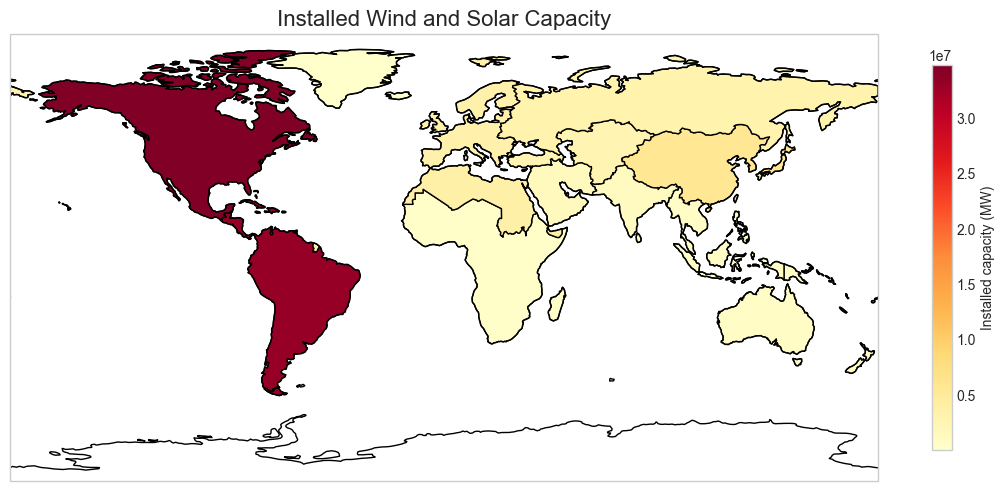

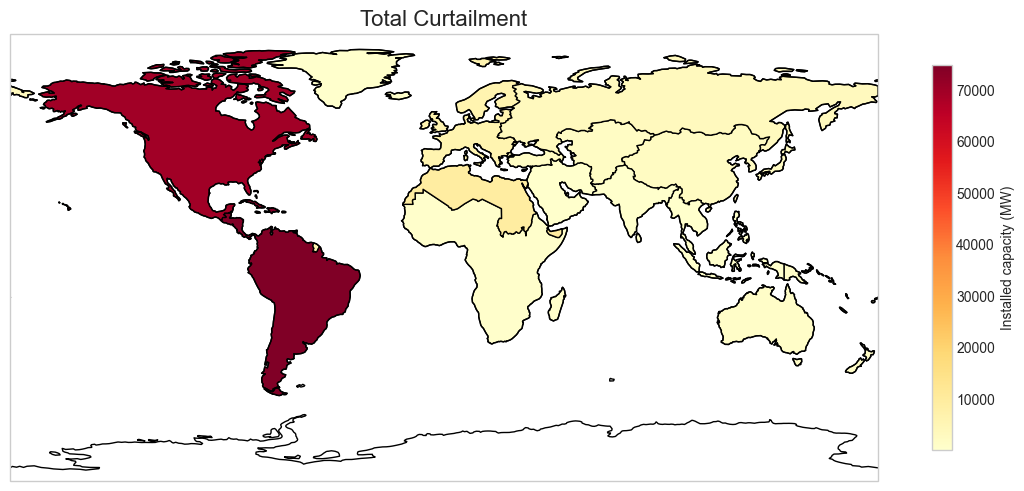

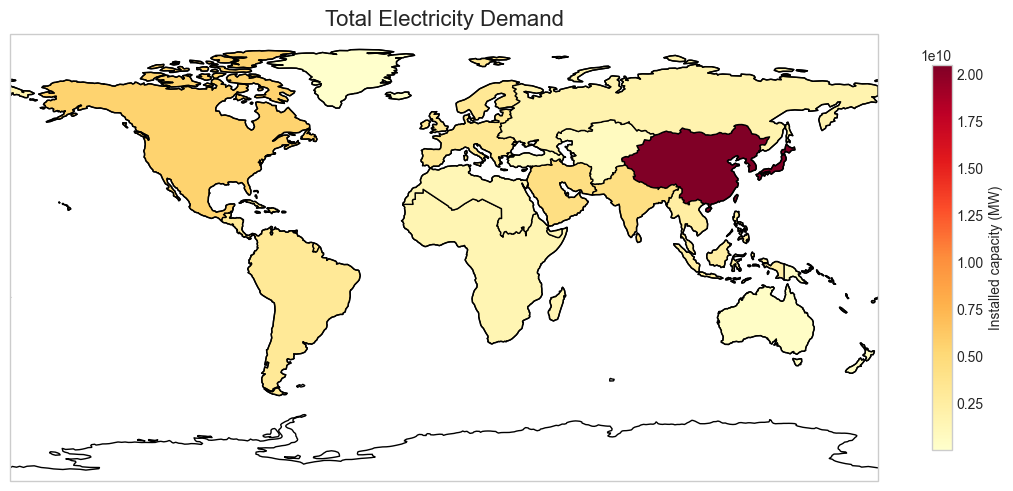

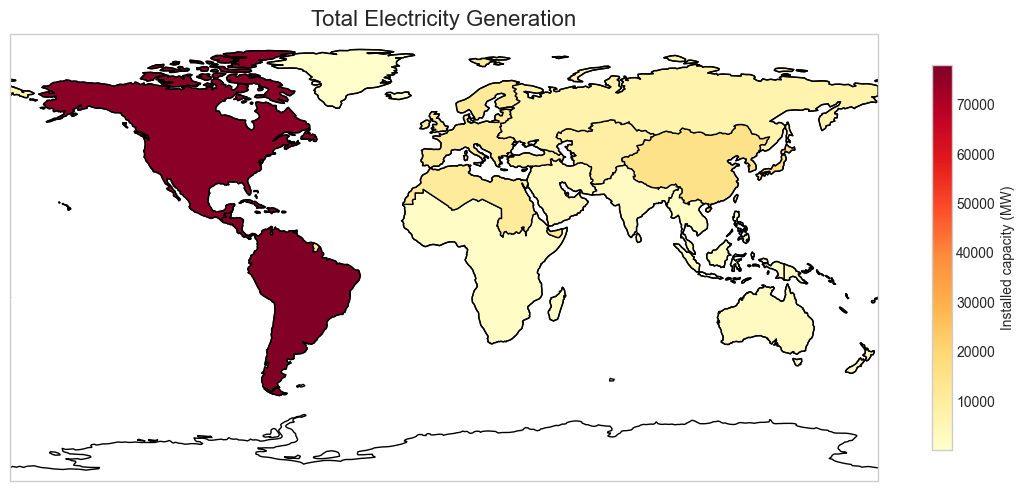

In [48]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

installed_capacity_dic = {}
curtailment_dic = {}
loads_dic = {}
generation_dic = {}
for key, value in regions_dic.items():
    installed_capacity_dic[key] = value["wind_installed"] + value["pv_installed"]
    curtailment_dic[key] = value["total_curtailment_yearly"]
    loads_dic[key] = value["total_load_yearly"] 
    generation_dic[key] = value["total_wind_yearly"] + value["total_pv_yearly"]
values_dics = [installed_capacity_dic, curtailment_dic, loads_dic, generation_dic]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    # Plotting the network with results
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

    # Add base map features
    ax.add_feature(cfeature.COASTLINE)

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.YlOrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree())

    # for i, bus in enumerate(n.buses.index, start=1):
    #     x, y = n.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Installed Wind and Solar Capacity', fontsize=16)
    elif i == 1:
        plt.title('Total Curtailment', fontsize=16)
    elif i == 2:
        plt.title('Total Electricity Demand', fontsize=16)
    elif i == 3:
        plt.title('Total Electricity Generation', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('Installed capacity (MW)')

    plt.show()

## Plotting of demand and supply graphs


north_america


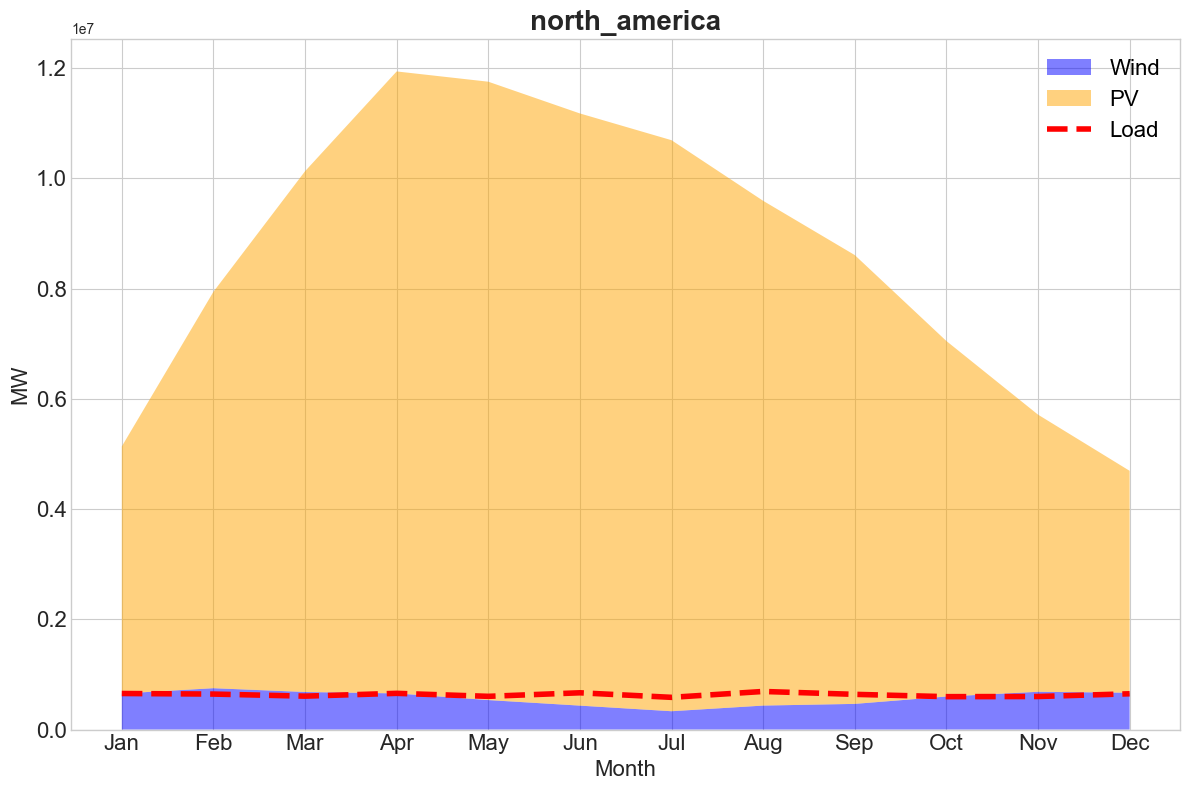

latin_america


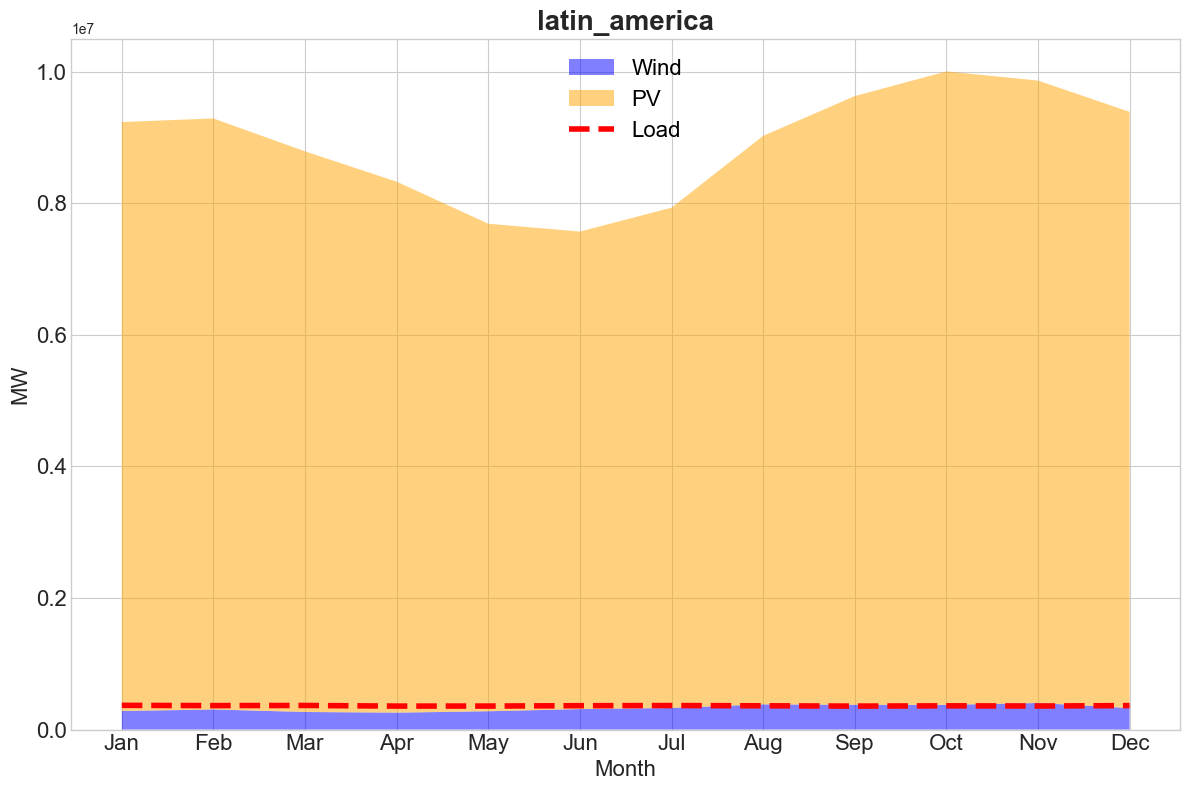

oceania


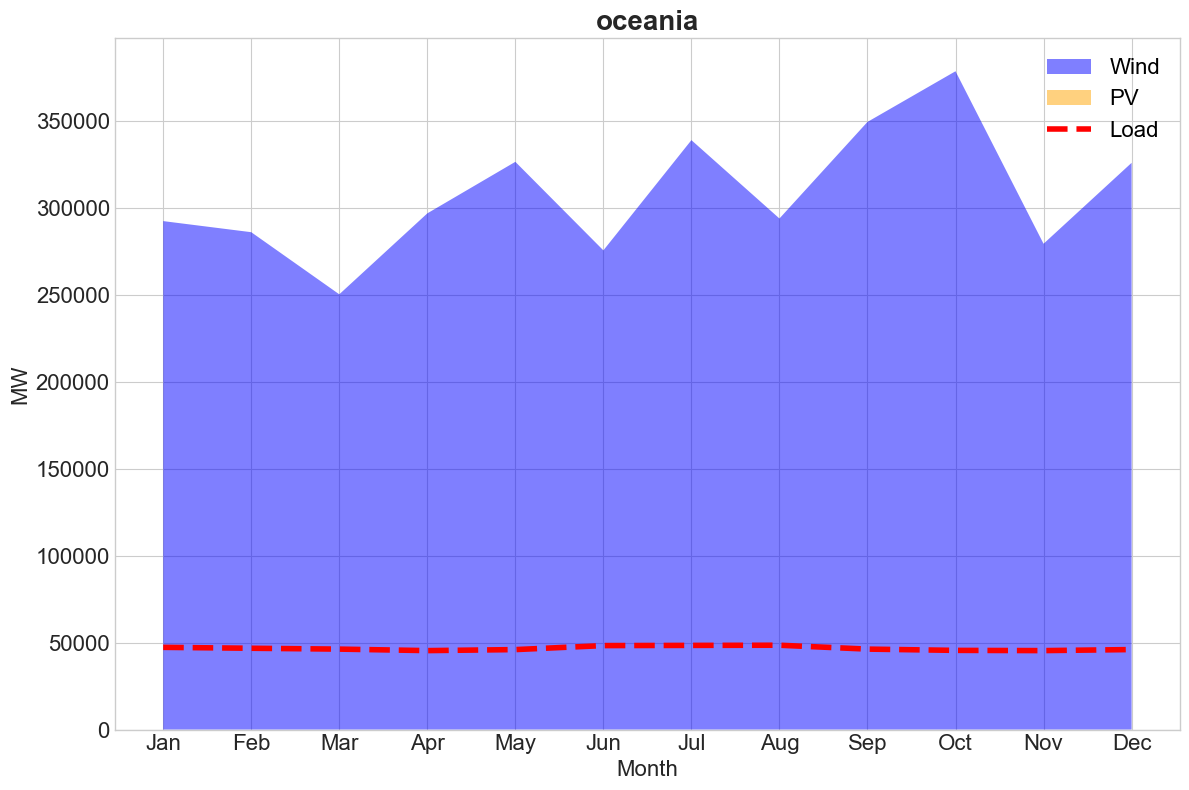

north_asia


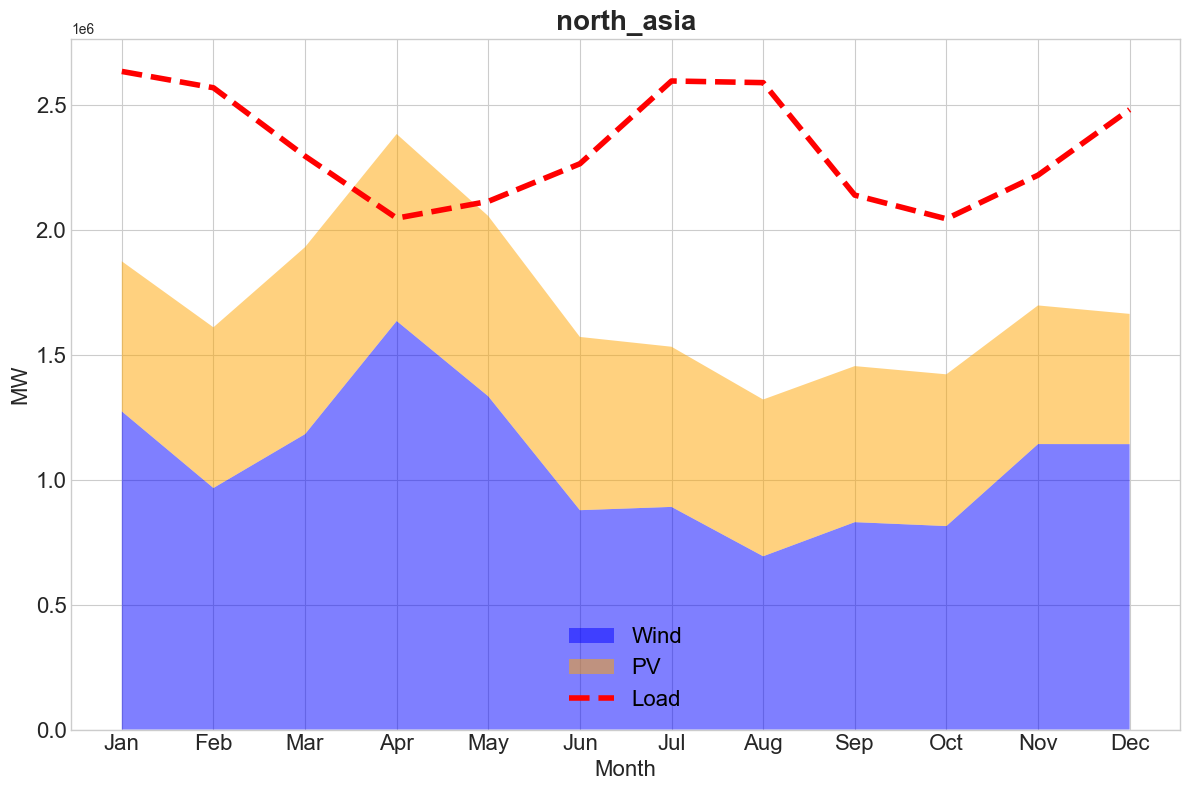

south_asia


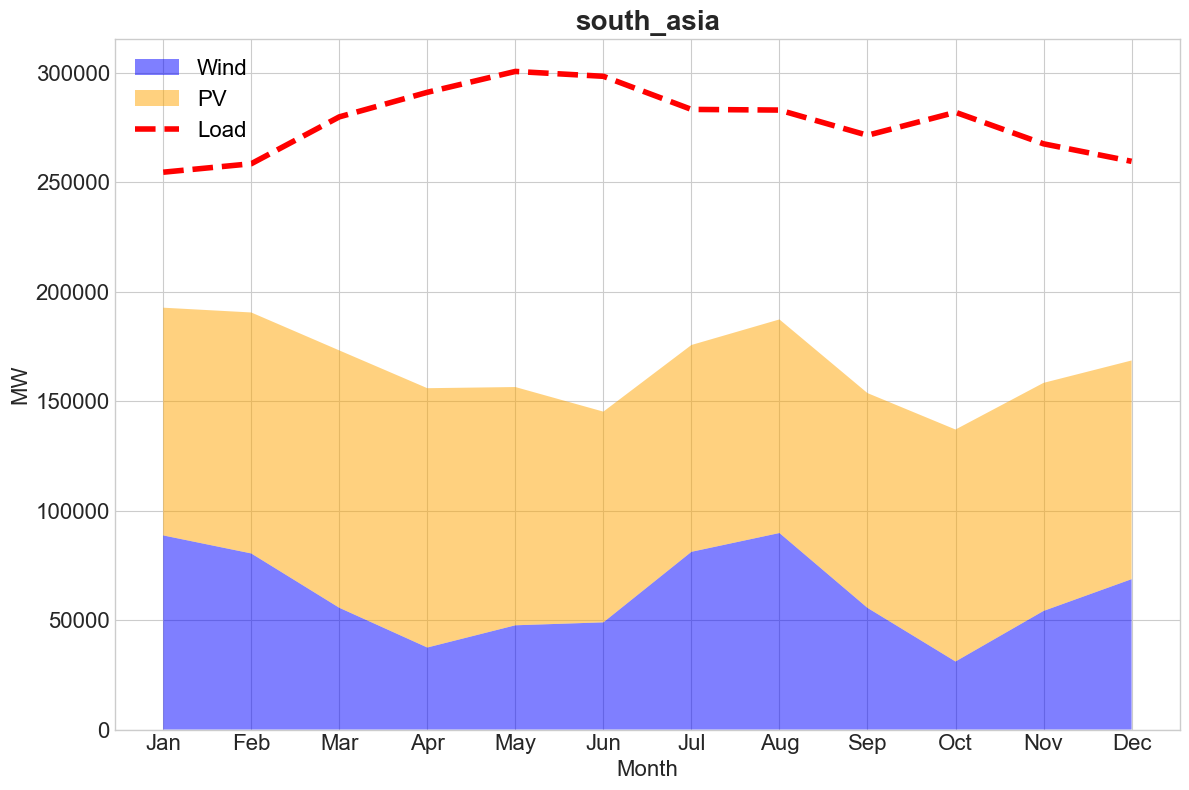

north_west_asia


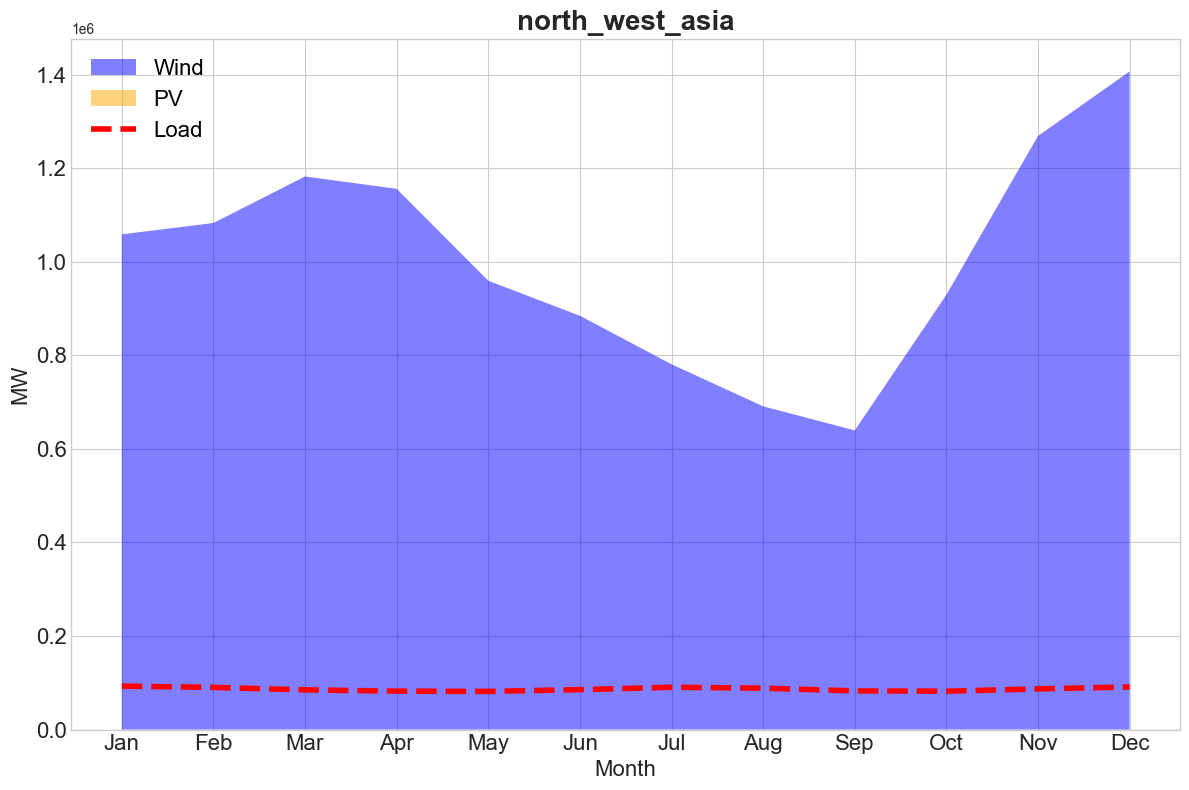

south_west_asia


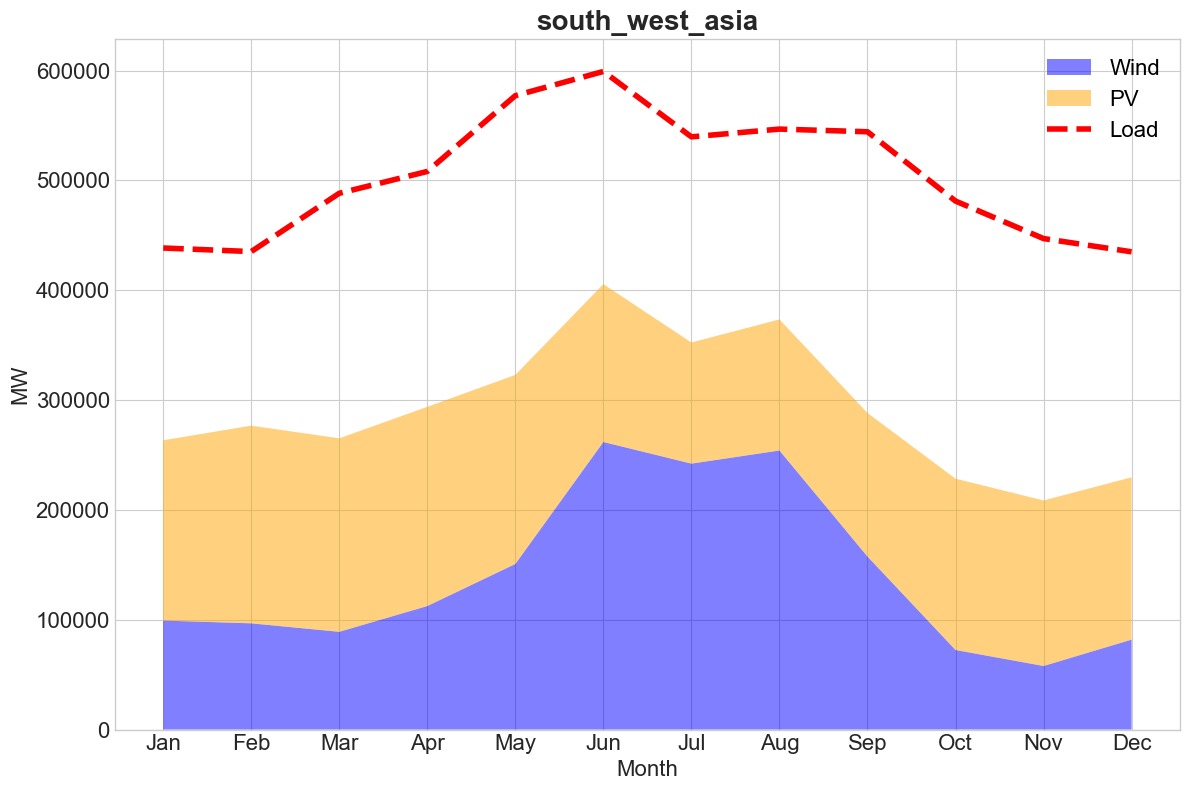

middle_east


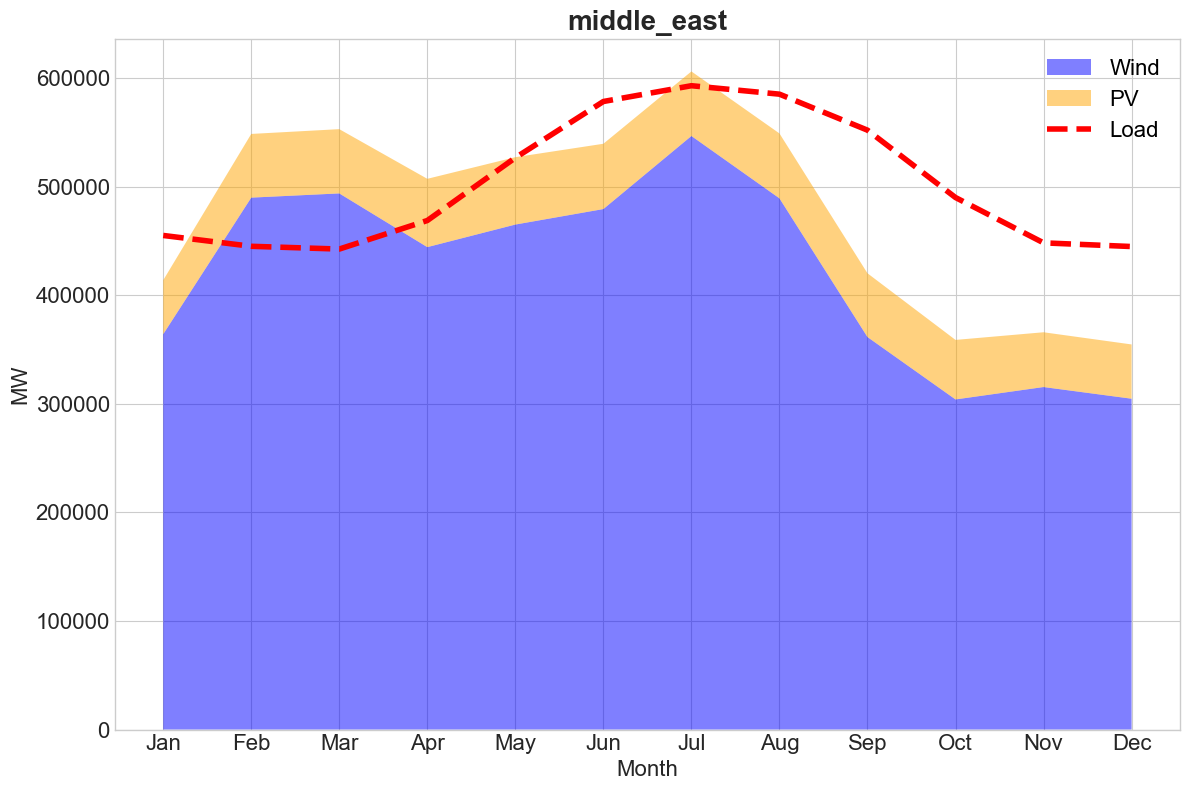

europe


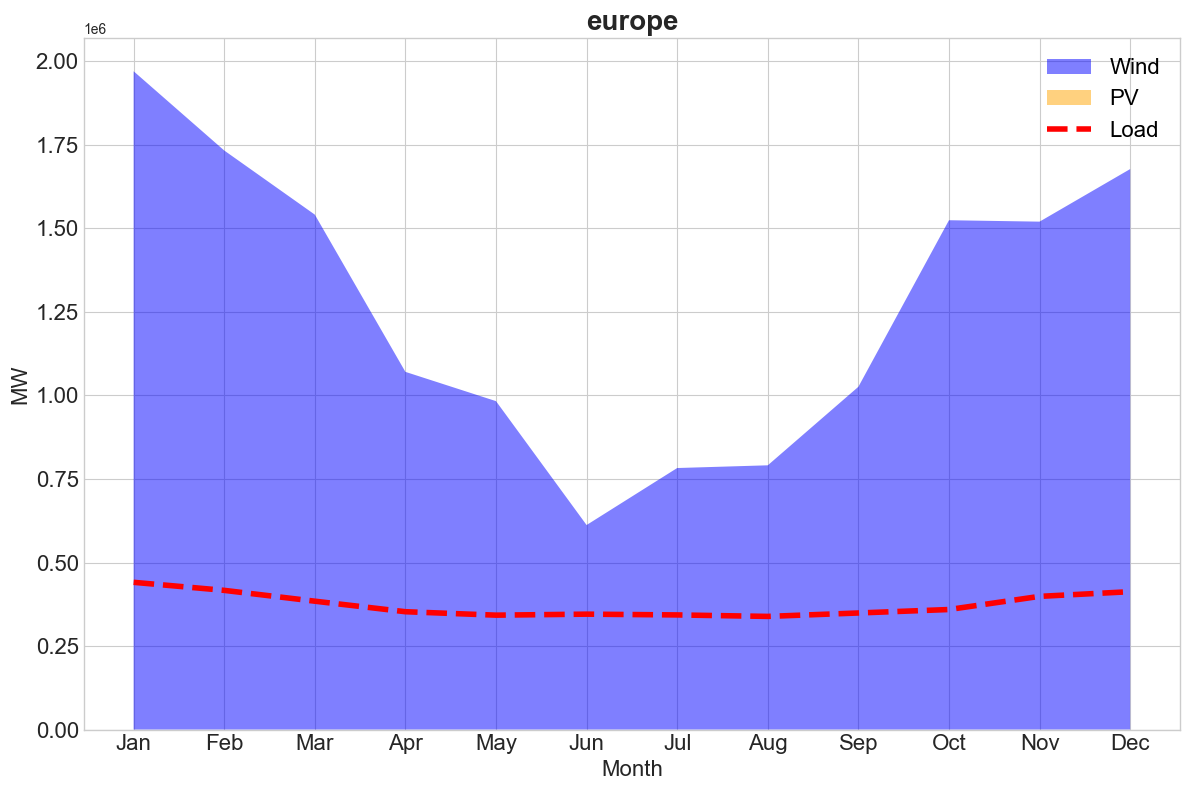

ups


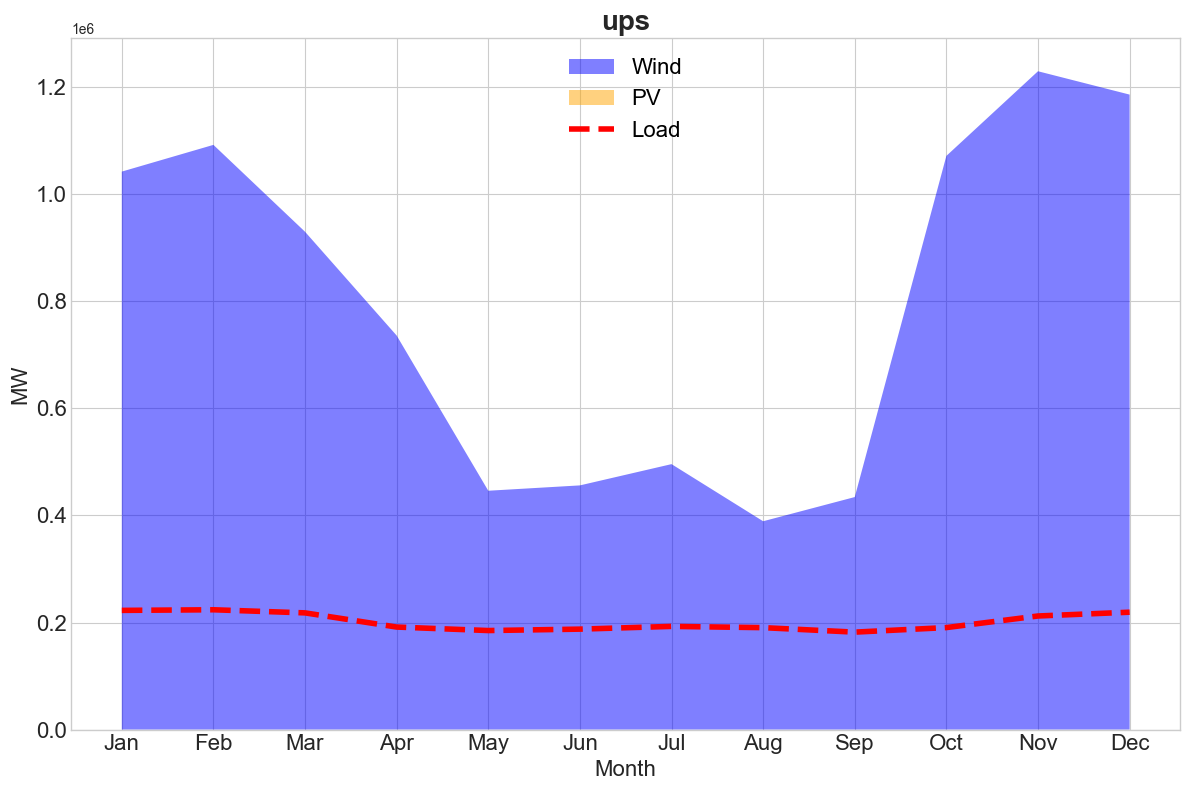

north_africa


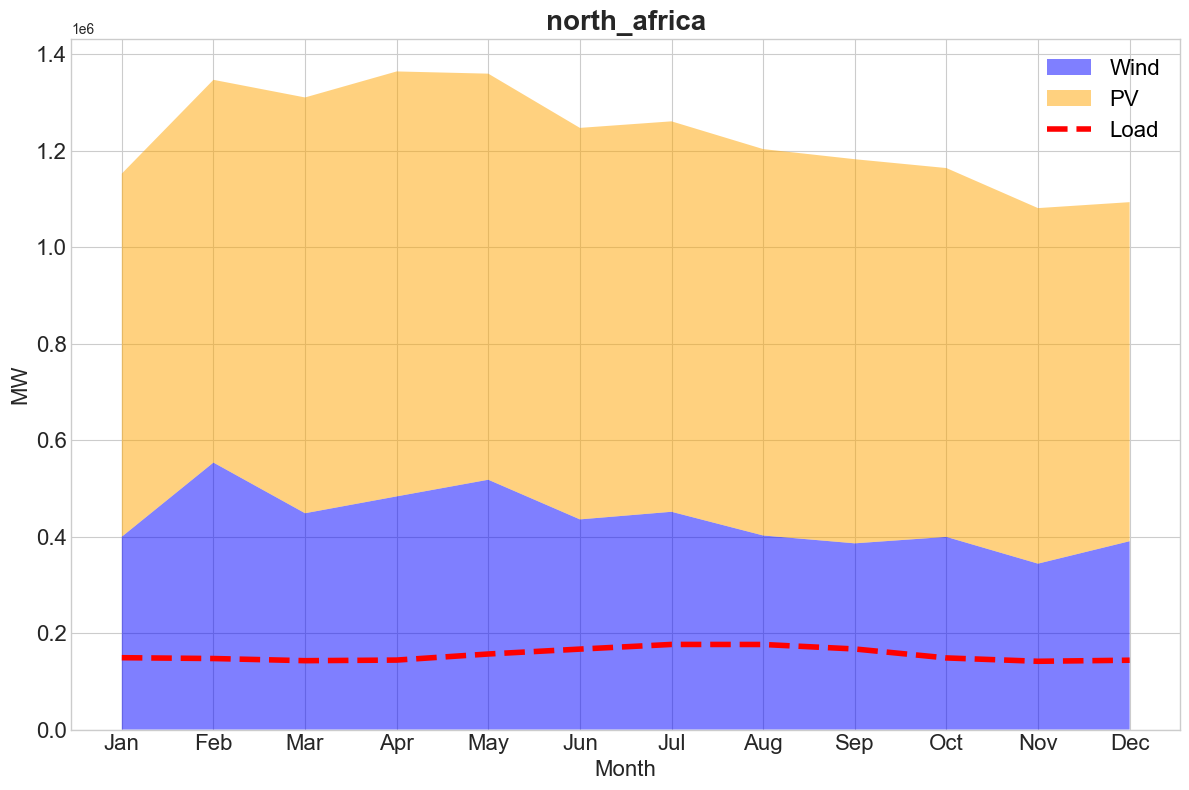

africa


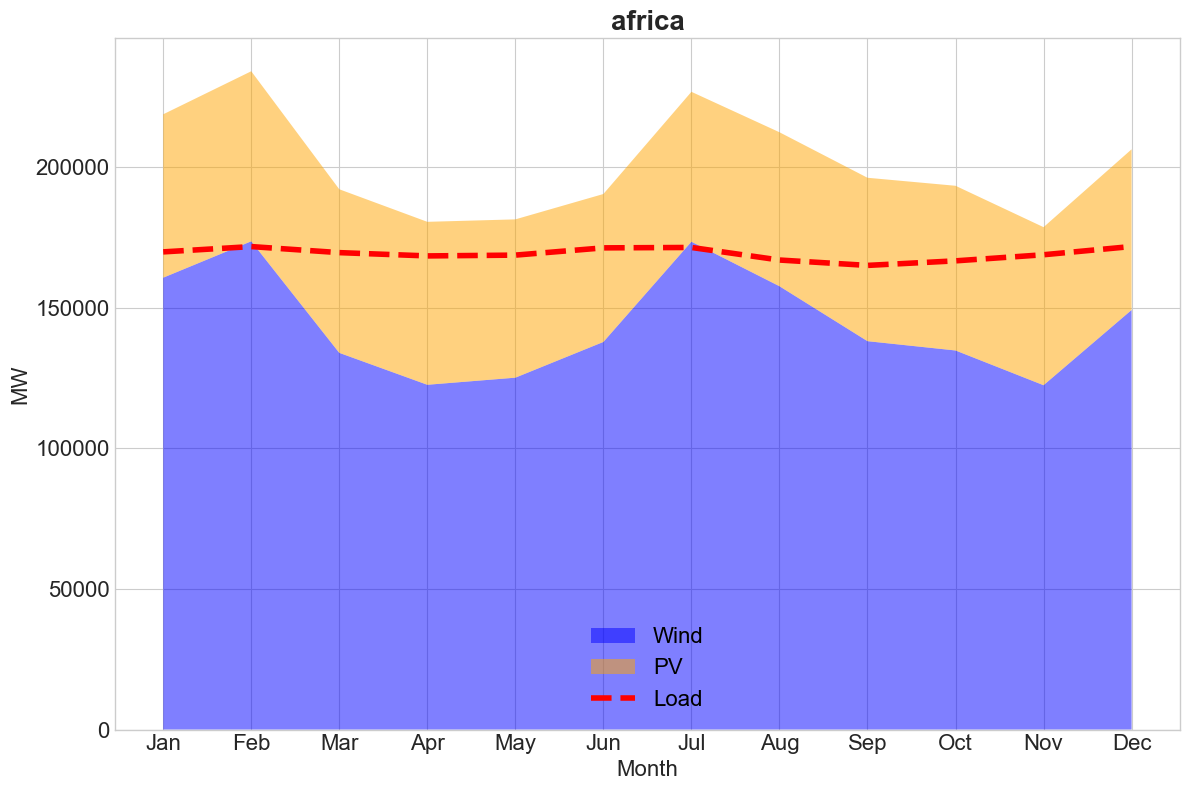

atlantic_north


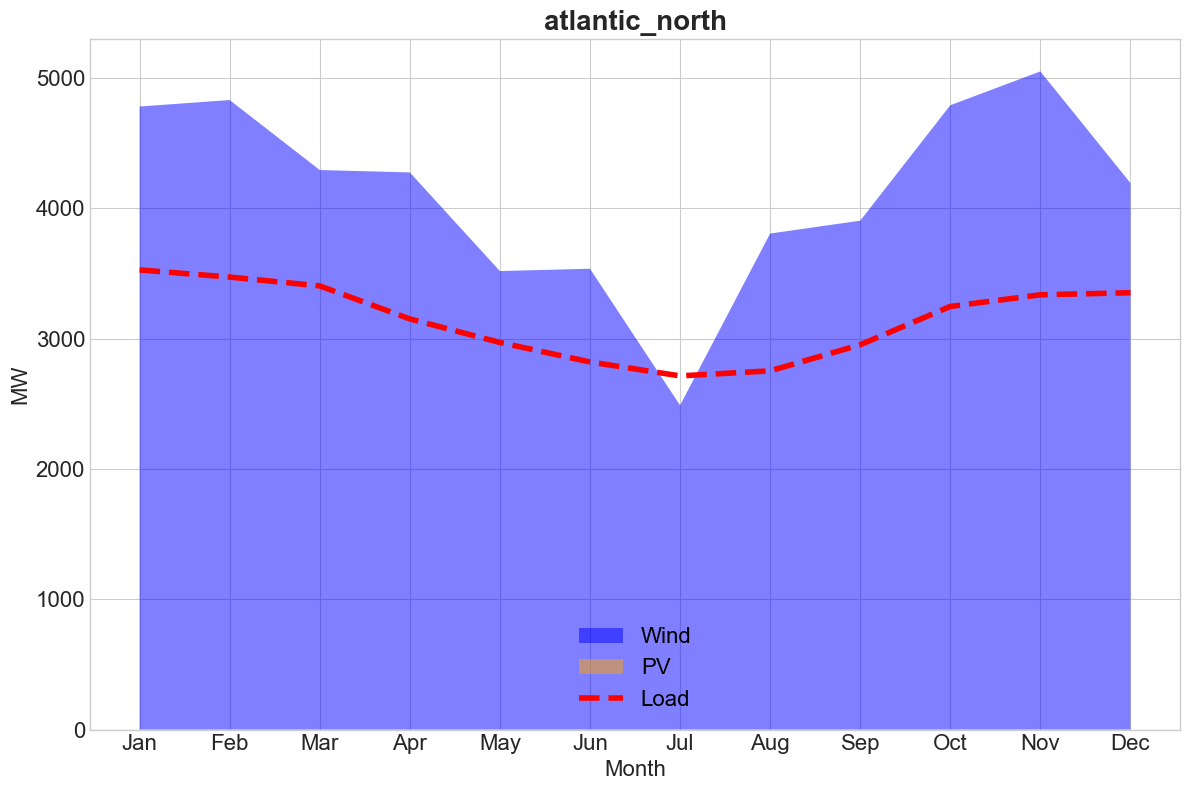

In [42]:
plt.style.use('seaborn-v0_8-whitegrid')  

for key, value in regions_dic.items():
    print(key)
    # series_l = value["load"]
    # load = series_l.groupby(series_l.index.to_period('M')).sum()
    load = value['mean_load_monthly']
    wind = value["mean_wind_monthly"]
    pv = value["mean_pv_monthly"]

    # Extract values and months
    months = load.index.month
    load_values = load.values
    wind_values = wind.values
    pv_values = pv.values

    plt.figure(figsize=(12, 8))
    
    # # Stacked area plot for wind and PV
    plt.stackplot(months, wind_values, pv_values, labels=['Wind', 'PV'], colors=['blue', 'orange'], alpha=0.5)
    
    # Plot load on top
    plt.plot(months, load_values, label='Load', linestyle='--', color='red', linewidth=4)
    
    plt.title(f'{key}', fontsize=20, fontweight='bold')
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('MW', fontsize=16)
    legend = plt.legend(loc='best', fontsize=16)
    for text in legend.get_texts():
        text.set_color('black')  # Set legend text color to black
        #text.set_fontweight('bold')  # Make legend text bold
    # Customize ticks
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
    plt.yticks(fontsize=16)
    # Tight layout to ensure everything fits without overlapping
    plt.tight_layout()
    
    
    # Show the plot
    plt.show()


## Plotting of losses

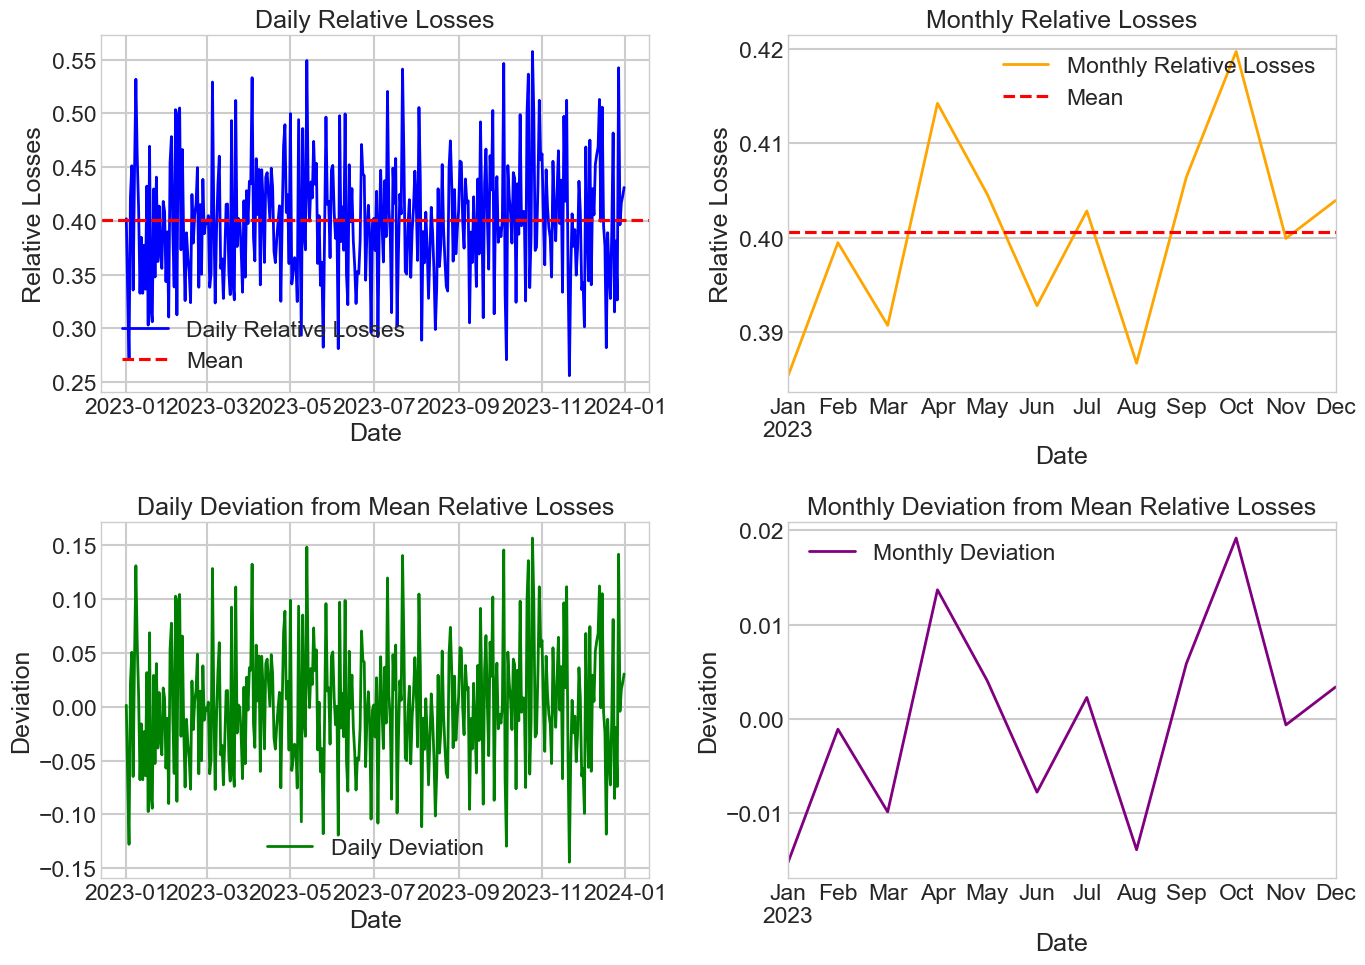

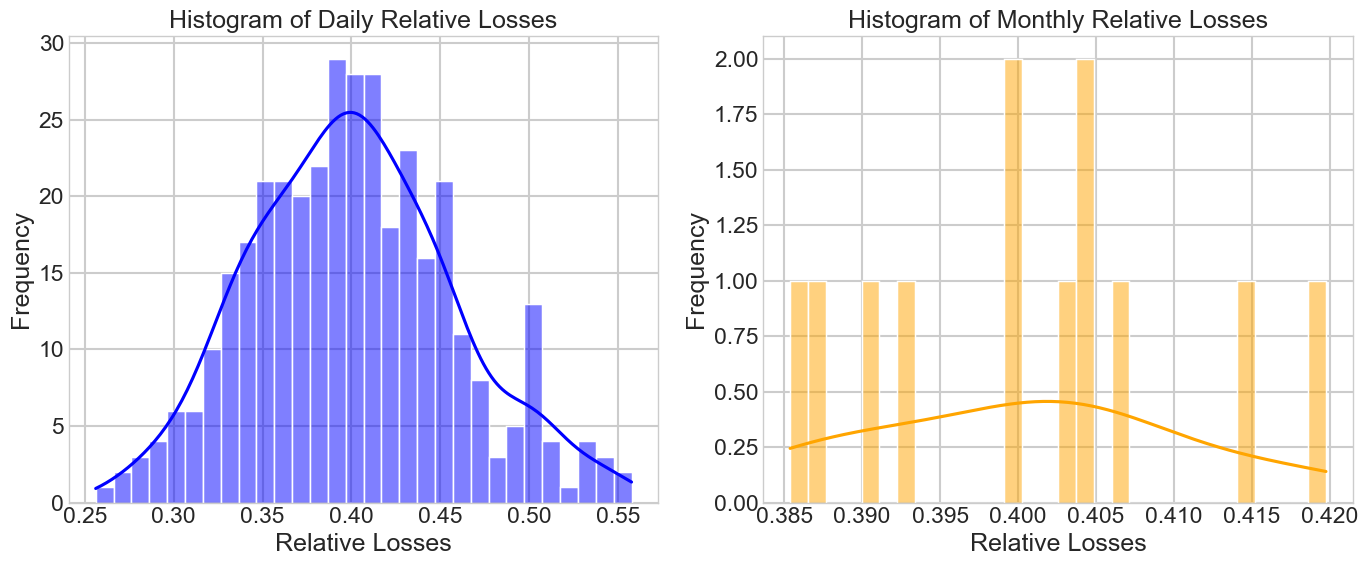

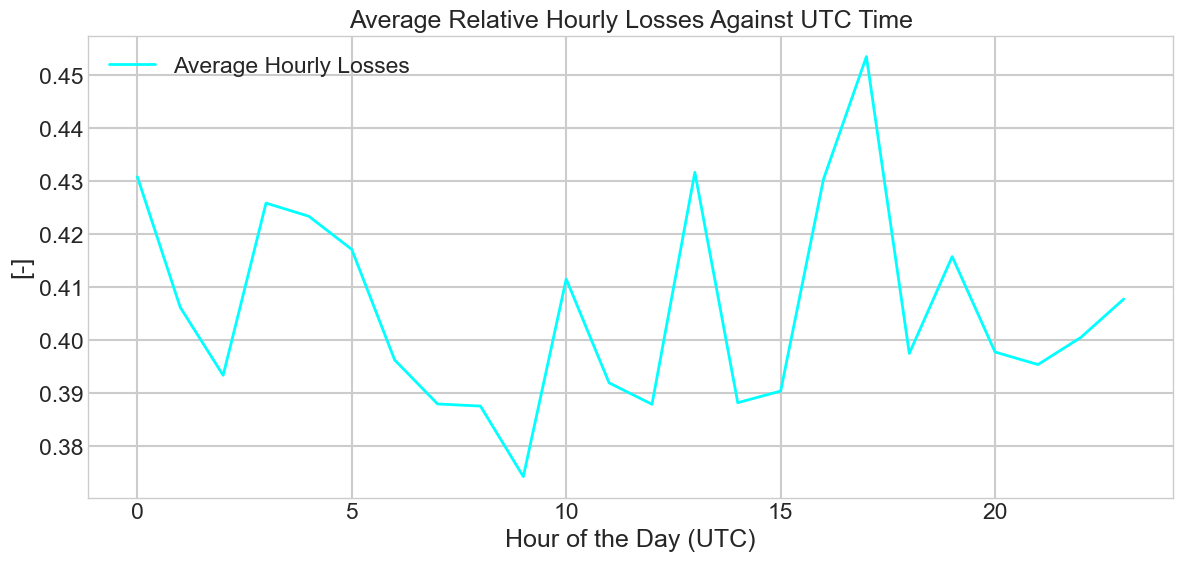

In [ ]:
# Plot daily relative losses and compare to mean
plt.figure(figsize=(14, 10))

# Daily Relative Losses
plt.subplot(2, 2, 1)
daily_losses_rel_to_gen.plot(label='Daily Relative Losses', color='blue', linewidth=2)
plt.axhline(y=daily_losses_rel_to_gen.mean(), color='red', linestyle='--', label='Mean')
plt.title('Daily Relative Losses')
plt.xlabel('Date')
plt.ylabel('Relative Losses')
plt.legend()

# Monthly Average Losses
plt.subplot(2, 2, 2)
monthly_losses_rel_to_gen.plot(label='Monthly Relative Losses', color='orange', linewidth=2)
plt.axhline(y=monthly_losses_rel_to_gen.mean(), color='red', linestyle='--', label='Mean')
plt.title('Monthly Relative Losses')
plt.xlabel('Date')
plt.ylabel('Relative Losses')
plt.legend()

# Daily Deviation
plt.subplot(2, 2, 3)
daily_deviation_gen.plot(label='Daily Deviation', color='green', linewidth=2)
plt.title('Daily Deviation from Mean Relative Losses')
plt.xlabel('Date')
plt.ylabel('Deviation')
plt.legend()

# Monthly Deviation
plt.subplot(2, 2, 4)
monthly_deviation_gen.plot(label='Monthly Deviation', color='purple', linewidth=2)
plt.title('Monthly Deviation from Mean Relative Losses')
plt.xlabel('Date')
plt.ylabel('Deviation')
plt.legend()

plt.tight_layout()
plt.show()

# Histogram of Daily and Monthly Relative Losses
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(daily_losses_rel_to_gen, bins=30, kde=True, color='blue')
plt.title('Histogram of Daily Relative Losses')
plt.xlabel('Relative Losses')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(monthly_losses_rel_to_gen, bins=30, kde=True, color='orange')
plt.title('Histogram of Monthly Relative Losses')
plt.xlabel('Relative Losses')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Losses against UTC time
hourly_losses = hourly_losses_rel_to_gen.groupby(hourly_losses_rel_to_gen.index.hour).mean()
plt.figure(figsize=(14, 6))
hourly_losses.plot(label='Average Hourly Losses', color='cyan', linewidth=2)
plt.title('Average Relative Hourly Losses Against UTC Time')
plt.xlabel('Hour of the Day (UTC)')
plt.ylabel('[-]')
plt.legend()
plt.show()


/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_503/94325181.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


NameError: name 'globalgrid' is not defined

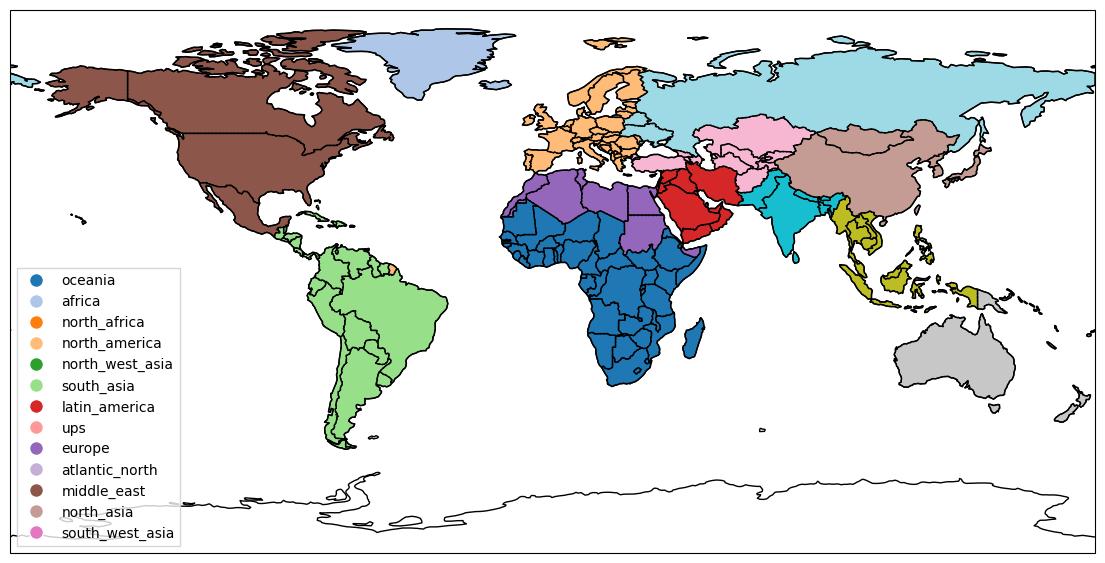

In [4]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend
world.plot(ax=ax, column='bus', cmap='tab20', legend=False, edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(n.buses.index, start=1):
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Plot links
for link in n.links.index:
    bus0 = n.links.loc[link, 'bus0']
    bus1 = n.links.loc[link, 'bus1']
    x0, y0 = n.buses.loc[bus0, ['x', 'y']]
    x1, y1 = n.buses.loc[bus1, ['x', 'y']]
    ax.plot([x0, x1], [y0, y1], color='blue', linewidth=2, zorder=4)


/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_10001/1885626021.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


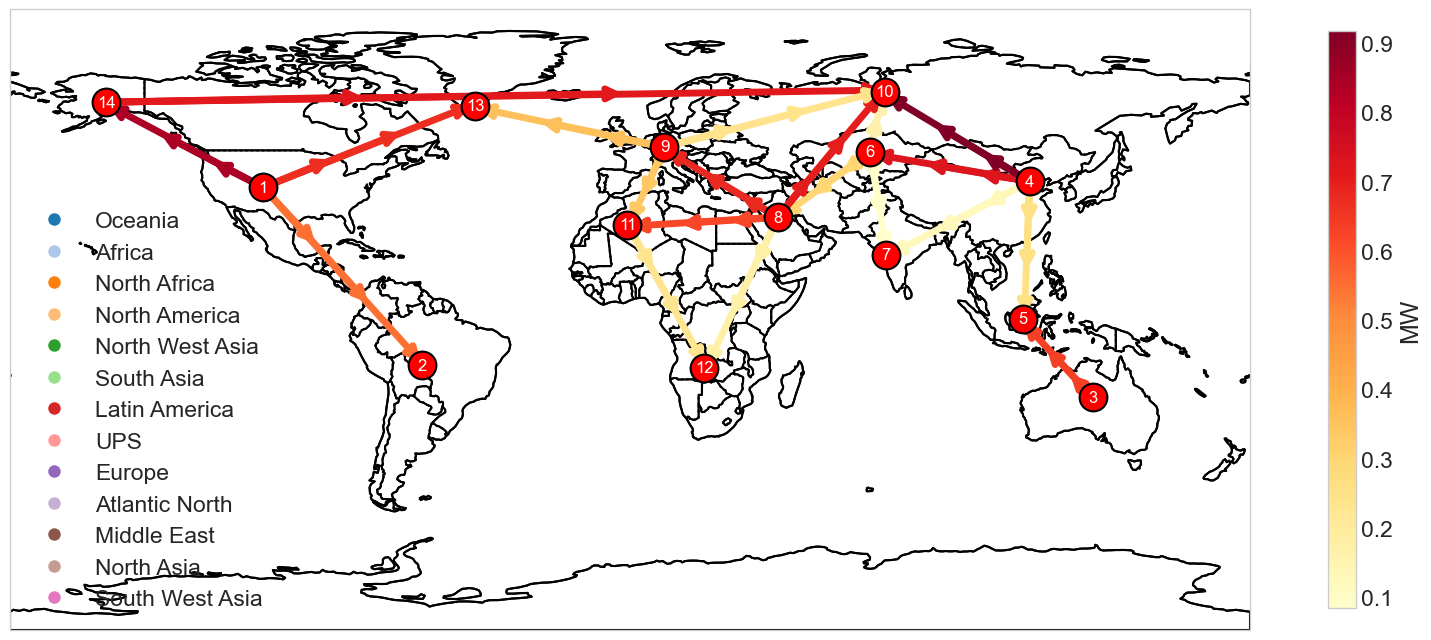

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from pyproj import Geod
import geopandas as gpd
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(20, 15))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend, setting facecolor to white
world.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())
world.plot(ax=ax, color='white', edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(n.buses.index, start=1):
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Define the Geod object for WGS84
geod = Geod(ellps="WGS84")

# Placeholder data for the direction and color of arrows
# This should be replaced with actual data
arrow_directions = {link: True for link in n.links.index}  # Example boolean data for direction
arrow_colors = {link: np.random.random() for link in n.links.index}  # Example values for color

# Normalize the arrow color values for the colormap
norm = mcolors.Normalize(vmin=min(arrow_colors.values()), vmax=max(arrow_colors.values()))
cmap = cm.YlOrRd

# Function to calculate offset coordinates
def offset_coordinates(x0, y0, x1, y1, offset):
    dx, dy = x1 - x0, y1 - y0
    length = np.sqrt(dx**2 + dy**2)
    offset_x = -offset * dy / length
    offset_y = offset * dx / length
    return offset_x, offset_y

# Plot links with directional arrows and heatmap colors at 1/3, 2/3, and 3/3 points
for link in n.links.index:
    bus0 = n.links.loc[link, 'bus0']
    bus1 = n.links.loc[link, 'bus1']
    x0, y0 = n.buses.loc[bus0, ['x', 'y']]
    x1, y1 = n.buses.loc[bus1, ['x', 'y']]
    
    offset_x, offset_y = offset_coordinates(x0, y0, x1, y1, 0.5)  # Adjust offset as needed
    
    # Calculate points at 1/3, 2/3, and 3/3 of the way along the line
    points = [
        (x0 + (x1 - x0) / 3 + offset_x, y0 + (y1 - y0) / 3 + offset_y),
        (x0 + 2 * (x1 - x0) / 3 + offset_x, y0 + 2 * (y1 - y0) / 3 + offset_y),
        (x1 + offset_x, y1 + offset_y)
    ]
    
    for point in points:
        # Determine the direction of the arrow
        if arrow_directions[link]:
            start, end = (x0, y0), point # outflow
        else:
            start, end = (x1, y1), point
        
        # Determine the color of the arrow
        color = cmap(norm(arrow_colors[link]))
        
        # Plot the arrow
        ax.annotate('', xy=end, xytext=start,
                    arrowprops=dict(arrowstyle='->', color=color, linewidth=5))

# Create a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('MW')

plt.show()
